
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [ ]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [ ]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

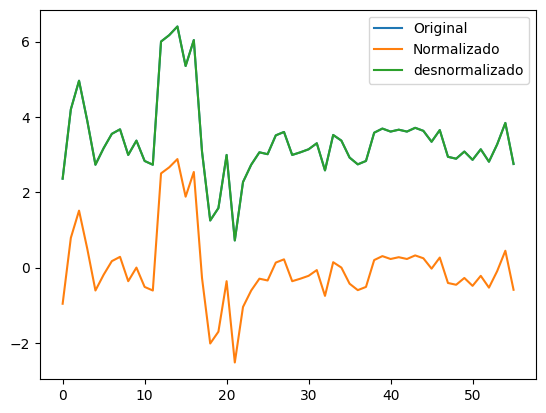

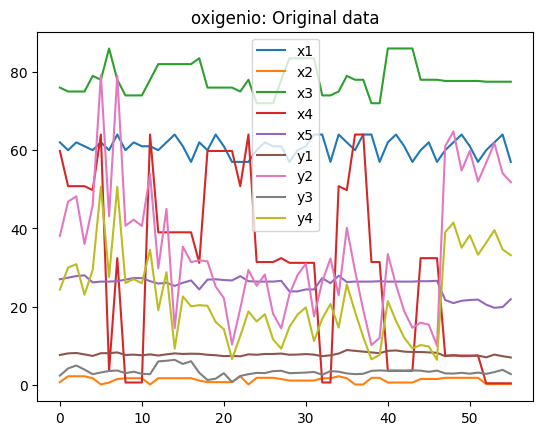

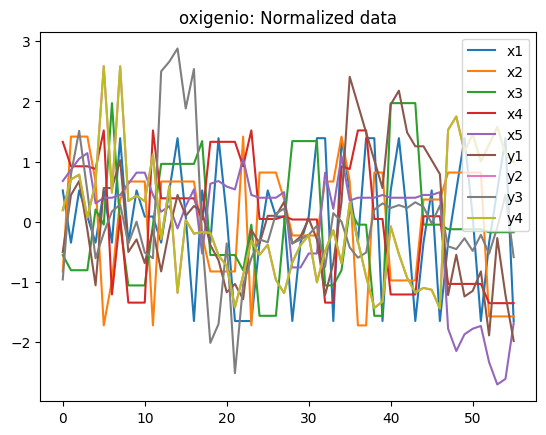

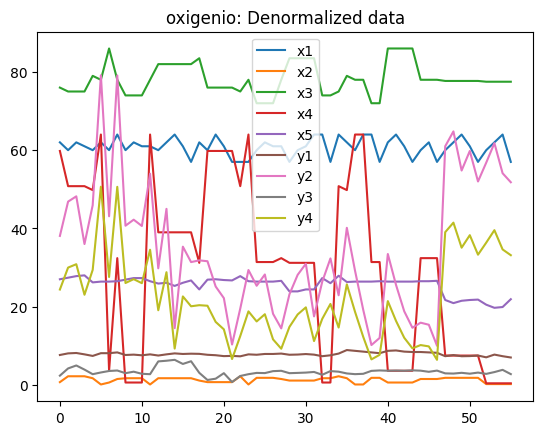

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y3"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y3")
test_out_scaler()
show_norm(label="oxigenio")


In [10]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

In [11]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [12]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [13]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [14]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.5548984480001309
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.4204787989999659
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.23747158099990884
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.3005379950000133
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.32835473099999035
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.257323273999873
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 7 +++++++++++++

2024-04-04 23:43:50.090462: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.39420163399995545
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_5] | 25 ++++++++++++++++++
Elapsed time:  0.32592106199990667
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_6,0.804263,-3.280712,-2.648039,-3.059877,0.216624,0.926917,0.439384,0.697490
model_3_5_5,0.815914,-2.936972,-2.528682,-2.791133,0.203729,0.852486,0.425008,0.651319
model_3_5_4,0.827571,-2.580133,-2.420830,-2.517449,0.190828,0.775218,0.412018,0.604300
model_3_5_3,0.838815,-2.217865,-2.333025,-2.246756,0.178385,0.696775,0.401442,0.557795
model_3_5_2,0.849057,-1.860979,-2.277488,-1.990297,0.167049,0.619497,0.394753,0.513735
model_3_5_1,0.857646,-1.521204,-2.267871,-1.760407,0.157544,0.545925,0.393595,0.474240
model_3_5_0,0.864043,-1.208015,-2.313953,-1.566632,0.150464,0.478109,0.399145,0.440949


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  1.2073639369998546
Stopped at epoch:  19
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.3987001559999044
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.3811900200000764
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.3937788149999051
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.37181579899993267
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.2887226590000864
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.3786160869

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.919926,-1.119621,0.885758,0.773369,0.088618,0.244405,0.241659,0.243113
model_3_6_1,0.921621,-1.161864,0.885212,0.770459,0.086742,0.249276,0.242812,0.246234
model_3_6_2,0.922922,-1.197703,0.884619,0.767868,0.085302,0.253409,0.244068,0.249013
model_3_6_3,0.923916,-1.228086,0.884005,0.765570,0.084202,0.256912,0.245366,0.251478
model_3_6_4,0.924669,-1.253856,0.883393,0.763536,0.083369,0.259883,0.246661,0.253661
model_3_6_5,0.925234,-1.275748,0.882796,0.761736,0.082744,0.262408,0.247923,0.255592
model_3_6_6,0.925651,-1.294388,0.882225,0.760145,0.082282,0.264557,0.249133,0.257299
model_3_6_7,0.925954,-1.310311,0.881684,0.758737,0.081947,0.266393,0.250276,0.258808
model_3_6_24,0.926042,-1.407001,0.877059,0.748943,0.081850,0.277542,0.260059,0.269315
model_3_6_23,0.926082,-1.405205,0.877170,0.749148,0.081806,0.277335,0.259826,0.269095


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.38150097400011873
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.37493779500005076
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.34877848800010725
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.3974591760002113
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.3322472560000733
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3761541720000423
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.331537571

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_8,0.809408,0.621651,0.476983,0.570411,0.210930,0.620028,0.699364,0.657363
model_3_7_7,0.843076,0.715344,0.557562,0.656668,0.173669,0.466487,0.591616,0.525371
model_3_7_6,0.867666,0.776142,0.633020,0.722169,0.146455,0.366852,0.490716,0.425141
model_3_7_5,0.885860,0.812082,0.707367,0.773119,0.126320,0.307955,0.391301,0.347176
model_3_7_4,0.903750,0.848209,0.784002,0.825116,0.106521,0.248751,0.288826,0.267610
model_3_7_3,0.921486,0.891683,0.856779,0.879692,0.086892,0.177507,0.191511,0.184097
model_3_7_2,0.934973,0.933362,0.916587,0.927916,0.071966,0.109205,0.111538,0.110303
model_3_7_0,0.937663,0.983453,0.972041,0.979121,0.068988,0.027117,0.037387,0.031950
model_3_7_1,0.940753,0.964807,0.955734,0.961843,0.065569,0.057673,0.059192,0.058388


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.5308954710001217
Stopped at epoch:  9
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.4489924039999096
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.3943544789999578
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.37432525400004124
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.3732961370001249
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.27496971399978065
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.3773156590

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.844596,-0.720250,0.951916,0.708505,0.171986,0.420697,0.069316,0.255341
model_3_8_1,0.870275,-0.413304,0.942221,0.746365,0.143567,0.345631,0.083291,0.222177
model_3_8_2,0.889037,-0.192961,0.929435,0.769030,0.122803,0.291745,0.101722,0.202323
model_3_8_3,0.902753,-0.036532,0.915761,0.781561,0.107624,0.253490,0.121434,0.191346
model_3_8_4,0.912763,0.073119,0.902333,0.787368,0.096545,0.226674,0.140792,0.186259
model_3_8_5,0.920038,0.148747,0.889689,0.788755,0.088494,0.208179,0.159018,0.185044
model_3_8_6,0.925279,0.199708,0.878045,0.787270,0.082694,0.195716,0.175803,0.186345
model_3_8_7,0.929002,0.232822,0.867449,0.783958,0.078574,0.187618,0.191078,0.189246
model_3_8_24,0.930493,0.172069,0.787308,0.712915,0.076924,0.202475,0.306606,0.251478
model_3_8_23,0.930931,0.178446,0.789111,0.715253,0.076439,0.200916,0.304007,0.249430


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.3774038249998739
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.34214171999997234
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.3847759469999801
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.31734480000000076
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.35913907799999834
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.3253814820000116
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.552584144

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_14,0.806340,-5.778525,0.201251,-0.741363,0.214324,0.821373,0.559359,0.698072
model_3_9_13,0.813410,-5.508700,0.232572,-0.672437,0.206500,0.788678,0.537425,0.670441
model_3_9_12,0.821115,-5.211570,0.266914,-0.596657,0.197973,0.752674,0.513376,0.640063
model_3_9_11,0.829474,-4.885335,0.304450,-0.513594,0.188722,0.713143,0.487089,0.606765
model_3_9_10,0.838490,-4.528546,0.345313,-0.422907,0.178744,0.669910,0.458473,0.570410
model_3_9_9,0.848144,-4.140341,0.389571,-0.324401,0.168060,0.622870,0.427480,0.530922
model_3_9_8,0.858382,-3.720686,0.437208,-0.218084,0.156730,0.572019,0.394119,0.488302
model_3_9_7,0.869104,-3.270825,0.488082,-0.104273,0.144863,0.517508,0.358493,0.442677
model_3_9_6,0.880157,-2.793578,0.541888,0.016331,0.132631,0.459679,0.320813,0.394330
model_3_9_5,0.891295,-2.294289,0.598050,0.142399,0.120305,0.399178,0.281483,0.343792


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  1.0246848130000217
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.4388345500001378
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.37415070900010505
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.37185361999991073
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.35165904099994805
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.4359389269998246
Stopped at epoch:  6
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.861688,-0.595307,0.909824,0.802728,0.153070,0.163966,0.124521,0.145404
model_4_7_24,0.868287,-3.096460,0.607738,0.351758,0.145768,0.421035,0.541662,0.477801
model_4_7_23,0.869886,-3.040088,0.612838,0.360416,0.143998,0.415241,0.534620,0.471420
model_4_7_22,0.871580,-2.978893,0.618270,0.369723,0.142123,0.408952,0.527119,0.464560
model_4_7_21,0.873372,-2.912570,0.624058,0.379721,0.140140,0.402135,0.519127,0.457190
model_4_7_20,0.875257,-2.840847,0.630224,0.390452,0.138053,0.394763,0.510612,0.449280
model_4_7_1,0.876216,-0.618009,0.888096,0.781896,0.136993,0.166299,0.154524,0.160758
model_4_7_19,0.877235,-2.763439,0.636797,0.401962,0.135865,0.386807,0.501535,0.440797
model_4_7_18,0.879299,-2.680088,0.643811,0.414300,0.133581,0.378240,0.491850,0.431703
model_4_7_17,0.881440,-2.590538,0.651305,0.427517,0.131211,0.369036,0.481502,0.421961


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.4034825759999876
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.390673617000175
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.39068358199983777
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.3024966810003207
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.31444616599992514
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.367569130999982
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.368444046000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_23,0.801085,-0.146008,-4.084100,-0.578583,0.220141,0.855544,0.574114,0.723107
model_4_8_22,0.803207,-0.131566,-4.036773,-0.560632,0.217792,0.844763,0.568770,0.714884
model_4_8_21,0.805508,-0.115774,-3.985093,-0.541011,0.215246,0.832974,0.562934,0.705896
model_4_8_20,0.807998,-0.098516,-3.928670,-0.519575,0.212490,0.820090,0.556562,0.696077
model_4_8_19,0.810688,-0.079659,-3.867078,-0.496160,0.209513,0.806012,0.549607,0.685351
model_4_8_18,0.813591,-0.059056,-3.799820,-0.470581,0.206300,0.790631,0.542012,0.673634
model_4_8_17,0.816719,-0.036539,-3.726319,-0.442627,0.202839,0.773821,0.533712,0.660829
model_4_8_16,0.820085,-0.011911,-3.645876,-0.412046,0.199113,0.755435,0.524628,0.646820
model_4_8_15,0.823706,0.015056,-3.557658,-0.378543,0.195106,0.735303,0.514666,0.631474
model_4_8_14,0.827597,0.044626,-3.460685,-0.341781,0.190800,0.713228,0.503716,0.614634


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.40642580399980943
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.3360005370000181
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.34377769799993985
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3905297039996185
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.3659576029999698
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.3331465770002069
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.5120378390

2024-04-04 23:48:00.025801: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3413165849997313
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_9] | 22 ++++++++++++++++++
Elapsed time:  0.31407345899970096
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 23 ++++++++++++++++++
Elapsed time:  0.2646124799998688
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_9] | 24 ++++++++++++++++++
Elapsed time:  0.3038413929998569
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [4_9] | 25 ++++++++++++++++++
Elapsed time:  0.4481128100001115
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_13,0.804067,-0.416167,-4.513935,-1.013102,0.216840,0.619613,0.742856,0.677610
model_4_9_12,0.813549,-0.305656,-4.240112,-0.885478,0.206346,0.571262,0.705966,0.634652
model_4_9_11,0.822689,-0.195743,-3.953159,-0.755792,0.196231,0.523172,0.667307,0.591000
model_4_9_10,0.831355,-0.087390,-3.650157,-0.624158,0.186641,0.475764,0.626485,0.546692
model_4_9_0,0.831431,0.907631,0.229767,0.791361,0.186556,0.040414,0.103768,0.070228
model_4_9_9,0.839406,0.018915,-3.328824,-0.490480,0.177730,0.429253,0.583194,0.501696
model_4_9_8,0.846671,0.122948,-2.987740,-0.354645,0.169690,0.383735,0.537242,0.455973
model_4_9_1,0.850268,0.851260,-0.113629,0.687889,0.165709,0.065078,0.150032,0.105056
model_4_9_7,0.852943,0.224680,-2.626000,-0.216504,0.162749,0.339224,0.488507,0.409475
model_4_9_6,0.857968,0.324295,-2.243306,-0.075872,0.157187,0.295640,0.436949,0.362138


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.8030326329999298
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.3000194510000256
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.3251332059999186
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.30198323600006916
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.4157841510000253
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.33883374400011235
Stopped at epoch:  6
1/1 [==============================] - 0s 2

2024-04-04 23:48:11.230700: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3211784139998599
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_0] | 13 ++++++++++++++++++
Elapsed time:  0.33290393800007223
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 14 ++++++++++++++++++
Elapsed time:  0.28297194800006764
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 15 ++++++++++++++++++
Elapsed time:  0.3702859680001893
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_0] | 16 ++++++++++++++++++
Elapsed time:  0.31475941999997303
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [5_0] | 17 ++++++++++++++++++
Elapsed time:  0.3617640819998087
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_0] | 18 ++++++++++++++++++
Elapsed time:  0.47517658000015217
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_0_0,0.800692,0.268158,-0.257752,0.146311,0.220575,0.633563,0.603483,0.619408
model_5_0_10,0.801361,0.168767,-0.462456,0.019825,0.219834,0.719607,0.701703,0.711182
model_5_0_9,0.802292,0.175381,-0.447354,0.028703,0.218804,0.713882,0.694456,0.704740
model_5_0_1,0.803058,0.254532,-0.282353,0.130048,0.217957,0.645360,0.615287,0.631208
model_5_0_8,0.803183,0.182626,-0.431004,0.038367,0.217818,0.707610,0.686611,0.697728
model_5_0_7,0.803996,0.190548,-0.413375,0.048857,0.216919,0.700752,0.678153,0.690117
model_5_0_2,0.804483,0.241762,-0.306620,0.114429,0.216380,0.656415,0.626931,0.642540
model_5_0_6,0.804680,0.199192,-0.394444,0.060209,0.216162,0.693268,0.669069,0.681880
model_5_0_5,0.805169,0.208600,-0.374226,0.072443,0.215621,0.685124,0.659369,0.673004
model_5_0_3,0.805196,0.229859,-0.330180,0.099579,0.215590,0.666720,0.638235,0.653315


DataFrame salvo em ../results/metrics_5_0
+++++++++++ [5_1] | 1 ++++++++++++++++++
Elapsed time:  0.35113989899991793
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_1] | 2 ++++++++++++++++++
Elapsed time:  0.37357850199987297
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_1] | 3 ++++++++++++++++++
Elapsed time:  0.36432294699989143
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_1] | 4 ++++++++++++++++++
Elapsed time:  0.3901803449998624
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_1] | 5 ++++++++++++++++++
Elapsed time:  0.32005565999998
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_1] | 6 ++++++++++++++++++
Elapsed time:  0.26086115099997187
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_1] | 7 ++++++++++++++++++
Elapsed time:  0.6248412110

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_1_2,0.811444,0.799328,-0.198958,0.540227,0.208676,0.287021,0.676752,0.470424
model_5_1_0,0.813883,0.867458,0.069507,0.660345,0.205977,0.189574,0.525217,0.347524
model_5_1_1,0.816691,0.839290,-0.049849,0.608512,0.202870,0.229864,0.592587,0.400557


DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Elapsed time:  0.33394255600023826
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Elapsed time:  0.29178543600028206
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Elapsed time:  0.3889101899999332
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Elapsed time:  0.34124342999984947
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Elapsed time:  0.4159275679999155
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Elapsed time:  0.34224826599984226
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Elapsed time:  0.30807748

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.888745,0.753107,0.647624,0.733618,0.123127,0.386524,0.168942,0.284132
model_5_4_1,0.892721,0.740789,0.655160,0.725640,0.118727,0.405810,0.165329,0.292642
model_5_4_2,0.895701,0.729734,0.661281,0.718345,0.115428,0.423117,0.162394,0.300424
model_5_4_3,0.897904,0.719902,0.665987,0.711700,0.112990,0.438509,0.160138,0.307511
model_5_4_4,0.899500,0.711223,0.669338,0.705665,0.111224,0.452096,0.158531,0.313948
model_5_4_24,0.899826,0.658060,0.640931,0.658347,0.110864,0.535326,0.172150,0.364420
model_5_4_23,0.899976,0.658562,0.642335,0.659033,0.110697,0.534540,0.171478,0.363687
model_5_4_22,0.900139,0.659133,0.643856,0.659799,0.110517,0.533647,0.170748,0.362871
model_5_4_21,0.900312,0.659784,0.645499,0.660653,0.110325,0.532626,0.169961,0.361960
model_5_4_20,0.900496,0.660529,0.647265,0.661604,0.110121,0.531461,0.169114,0.360945


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.36881917499977135
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.35610396599986416
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.3897278239996922
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.30797935399959897
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.4989827620001961
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.31118961099991793
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.48554511

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.917271,0.767582,0.901728,0.911908,0.091557,0.070387,0.053554,0.062466
model_5_5_1,0.930168,0.796900,0.889793,0.914220,0.077283,0.061508,0.060059,0.060826
model_5_5_2,0.939530,0.806818,0.873303,0.910499,0.066923,0.058505,0.069045,0.063465
model_5_5_24,0.939971,0.375883,0.542791,0.693529,0.066435,0.189012,0.249161,0.217317
model_5_5_23,0.940749,0.386040,0.548911,0.698039,0.065573,0.185936,0.245826,0.214119
model_5_5_22,0.941593,0.397196,0.555649,0.702998,0.064640,0.182557,0.242154,0.210603
model_5_5_21,0.942502,0.409432,0.563057,0.708444,0.063633,0.178852,0.238117,0.206741
model_5_5_20,0.943479,0.422830,0.571193,0.714416,0.062552,0.174794,0.233683,0.202507
model_5_5_19,0.944522,0.437469,0.580114,0.720952,0.061398,0.170361,0.228821,0.197872
model_5_5_18,0.945630,0.453431,0.589882,0.728094,0.060172,0.165527,0.223498,0.192807


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.2830604890000359
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.3723594570001296
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.3699771609999516
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.31690500600007
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.3189402699999846
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.3756297140002971
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.30428168899970

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.907857,0.171515,0.509972,0.333741,0.101975,0.428032,0.230845,0.335238
model_5_6_23,0.908875,0.179249,0.517881,0.341430,0.100849,0.424036,0.227119,0.331370
model_5_6_22,0.909994,0.187800,0.526619,0.349928,0.099610,0.419619,0.223003,0.327094
model_5_6_21,0.911222,0.197247,0.536262,0.359312,0.098251,0.414738,0.218461,0.322372
model_5_6_20,0.912569,0.207677,0.546894,0.369665,0.096760,0.409350,0.213452,0.317163
model_5_6_19,0.914043,0.219179,0.558604,0.381078,0.095129,0.403407,0.207936,0.311420
model_5_6_18,0.915652,0.231852,0.571485,0.393642,0.093349,0.396860,0.201867,0.305098
model_5_6_17,0.917403,0.245793,0.585631,0.407452,0.091411,0.389657,0.195203,0.298150
model_5_6_16,0.919304,0.261106,0.601137,0.422609,0.089307,0.381745,0.187899,0.290523
model_5_6_15,0.921358,0.277893,0.618095,0.439205,0.087033,0.373072,0.179910,0.282172


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.37501183700032925
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.326495924000028
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.33503163100021993
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.34267249799995625
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.3610165079999206
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.43858097700012877
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.379992564

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_24,0.866631,-0.580812,-1.615598,-0.803766,0.147600,0.628921,0.323141,0.485025
model_5_7_23,0.868230,-0.564678,-1.569009,-0.781054,0.145831,0.622502,0.317385,0.478918
model_5_7_22,0.869993,-0.546700,-1.517659,-0.755870,0.143880,0.615350,0.311041,0.472146
model_5_7_21,0.871936,-0.526665,-1.461121,-0.727953,0.141730,0.607379,0.304056,0.464639
model_5_7_20,0.874073,-0.504345,-1.398950,-0.697028,0.139364,0.598499,0.296375,0.456323
model_5_7_19,0.876420,-0.479478,-1.330685,-0.662790,0.136766,0.588606,0.287942,0.447117
model_5_7_18,0.878995,-0.451784,-1.255851,-0.624917,0.133917,0.577588,0.278696,0.436933
model_5_7_17,0.881811,-0.420957,-1.173969,-0.583067,0.130800,0.565323,0.268580,0.425680
model_5_7_16,0.884884,-0.386668,-1.084572,-0.536879,0.127400,0.551681,0.257536,0.413260
model_5_7_15,0.888225,-0.348572,-0.987210,-0.485988,0.123702,0.536525,0.245507,0.399576


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.4383200500001294
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.32677309400014565
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.32602739399999336
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.2912100210000972
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.36594267400005265
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3961760460001642
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.430507101

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.888582,0.899248,0.990897,0.934937,0.123307,0.089923,0.005364,0.050131
model_5_8_1,0.905561,0.890160,0.984464,0.927048,0.104516,0.098034,0.009155,0.056209
model_5_8_2,0.918687,0.880459,0.975318,0.917808,0.089990,0.106692,0.014545,0.063329
model_5_8_3,0.928801,0.870578,0.964830,0.907974,0.078796,0.115511,0.020725,0.070906
model_5_8_4,0.936554,0.860793,0.953788,0.897998,0.070216,0.124244,0.027233,0.078592
model_5_8_5,0.942451,0.851281,0.942654,0.888158,0.063690,0.132734,0.033794,0.086174
model_5_8_6,0.946890,0.842154,0.931712,0.878623,0.058777,0.140879,0.040242,0.093520
model_5_8_7,0.950185,0.833480,0.921134,0.869496,0.055130,0.148621,0.046475,0.100553
model_5_8_8,0.952583,0.825294,0.911025,0.860837,0.052476,0.155927,0.052433,0.107224
model_5_8_24,0.953553,0.752829,0.818670,0.783158,0.051404,0.220604,0.106857,0.167076


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.3659322099997553
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.40379197699985525
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.30848675299967
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.38155869000001985
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.37944996400028685
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.3618182509999315
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.31538521799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.966923,0.875992,0.994193,0.960603,0.036607,0.043620,0.005788,0.025817
model_5_9_1,0.971368,0.869636,0.992769,0.957777,0.031688,0.045856,0.007208,0.027669
model_5_9_2,0.974734,0.862139,0.990773,0.954218,0.027962,0.048494,0.009197,0.030001
model_5_9_3,0.977255,0.853994,0.988406,0.950208,0.025172,0.051359,0.011556,0.032628
model_5_9_4,0.979116,0.845563,0.985818,0.945960,0.023113,0.054324,0.014136,0.035412
model_5_9_5,0.980461,0.837103,0.983124,0.941627,0.021624,0.057300,0.016821,0.038251
model_5_9_24,0.980470,0.744414,0.950965,0.892268,0.021614,0.089904,0.048875,0.070596
model_5_9_23,0.980626,0.746418,0.951683,0.893351,0.021441,0.089199,0.048159,0.069886
model_5_9_22,0.980793,0.748627,0.952475,0.894546,0.021256,0.088422,0.047370,0.069103
model_5_9_21,0.980971,0.751063,0.953347,0.895862,0.021060,0.087565,0.046502,0.068241


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.6993080920001375
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.46989636800026346
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.308595485999831
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.3910215219998463
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.3686133669998526
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.30758684100010214
Stopped at epoch:  6
1/1 [==============================] - 0s 19m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_0_0,0.807544,0.561389,0.629208,0.609255,0.212992,0.541257,0.488286,0.516330
model_6_0_1,0.817716,0.569281,0.623628,0.610540,0.201735,0.531517,0.495634,0.514631
model_6_0_2,0.825781,0.575956,0.617884,0.611146,0.192809,0.523281,0.503198,0.513830
model_6_0_3,0.832169,0.581627,0.612157,0.611264,0.185740,0.516282,0.510741,0.513674
model_6_0_4,0.837217,0.586462,0.606566,0.611032,0.180153,0.510316,0.518103,0.513981
model_6_0_5,0.841196,0.590593,0.601193,0.610555,0.175749,0.505218,0.525179,0.514611
model_6_0_6,0.844322,0.594132,0.596088,0.609911,0.172289,0.500851,0.531900,0.515463
model_6_0_7,0.846769,0.597168,0.591283,0.609158,0.169582,0.497105,0.538229,0.516457
model_6_0_8,0.848674,0.599778,0.586789,0.608341,0.167473,0.493884,0.544147,0.517537
model_6_0_9,0.850149,0.602025,0.582611,0.607493,0.165841,0.491111,0.549648,0.518658


DataFrame salvo em ../results/metrics_6_0
+++++++++++ [6_1] | 1 ++++++++++++++++++
Elapsed time:  0.33677212499969755
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Elapsed time:  0.3173366179998993
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Elapsed time:  0.4149768919996859
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Elapsed time:  0.35780760099987674
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_1] | 5 ++++++++++++++++++
Elapsed time:  0.5121394480001982
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_1] | 6 ++++++++++++++++++
Elapsed time:  0.3798728649999248
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_1] | 7 ++++++++++++++++++
Elapsed time:  0.3699148280

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_1_9,0.807010,0.824577,-3.817531,0.641505,0.213583,0.578785,0.782360,0.674585
model_6_1_8,0.817497,0.836206,-3.493265,0.665470,0.201977,0.540416,0.729699,0.629490
model_6_1_7,0.827709,0.847882,-3.161938,0.689764,0.190675,0.501894,0.675892,0.583776
model_6_1_6,0.837170,0.859276,-2.833995,0.713660,0.180205,0.464301,0.622635,0.538811
model_6_1_5,0.845470,0.870255,-2.519828,0.736610,0.171019,0.428078,0.571614,0.495625
model_6_1_4,0.852315,0.880863,-2.227025,0.758350,0.163444,0.393075,0.524064,0.454717
model_6_1_3,0.857274,0.890968,-1.963730,0.778423,0.157955,0.359736,0.481305,0.416945
model_6_1_2,0.859672,0.900005,-1.738967,0.795940,0.155302,0.329918,0.444804,0.383982
model_6_1_1,0.860178,0.908419,-1.519461,0.812665,0.154742,0.302159,0.409157,0.352511
model_6_1_0,0.861294,0.920809,-1.267627,0.834394,0.153506,0.261281,0.368259,0.311623


DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Elapsed time:  0.2962052399998356
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Elapsed time:  0.34267651200025284
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Elapsed time:  0.3506134170002042
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Elapsed time:  0.29041072400013945
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Elapsed time:  0.32659822999994503
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Elapsed time:  0.5232814490000237
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Elapsed time:  0.401867581

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_0,0.825271,0.736973,0.042785,0.519373,0.193374,0.079913,0.233726,0.152296
model_6_2_1,0.846504,0.681592,-0.019934,0.468517,0.169874,0.096740,0.249041,0.168411
model_6_2_22,0.852533,-0.153677,-2.023384,-0.681981,0.163203,0.350513,0.738230,0.532968
model_6_2_21,0.854586,-0.135662,-1.973980,-0.654921,0.160931,0.345039,0.726167,0.524394
model_6_2_20,0.856804,-0.115836,-1.919644,-0.625153,0.158476,0.339016,0.712900,0.514961
model_6_2_19,0.859190,-0.094058,-1.859970,-0.592460,0.155835,0.332399,0.698329,0.504601
model_6_2_18,0.861743,-0.070193,-1.794525,-0.556613,0.153009,0.325148,0.682349,0.493243
model_6_2_2,0.862174,0.620031,-0.091619,0.411272,0.152533,0.115443,0.266544,0.186550
model_6_2_17,0.864458,-0.044110,-1.722874,-0.517390,0.150005,0.317224,0.664853,0.480814
model_6_2_16,0.867321,-0.015706,-1.644588,-0.474583,0.146837,0.308594,0.645738,0.467250


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.3790955979998216
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.386071844000071
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.31588370999998006
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.3816944639997928
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.3568675520000397
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.3876115920002121
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.278149495999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_24,0.822104,-0.835405,0.061212,0.001633,0.196878,0.343810,0.987253,0.646607
model_6_3_23,0.823717,-0.821366,0.071197,0.011412,0.195093,0.341180,0.976753,0.640273
model_6_3_22,0.825479,-0.805797,0.082189,0.022195,0.193143,0.338264,0.965193,0.633289
model_6_3_21,0.827400,-0.788539,0.094277,0.034074,0.191017,0.335031,0.952481,0.625596
model_6_3_20,0.829489,-0.769408,0.107557,0.047151,0.188705,0.331447,0.938516,0.617127
model_6_3_19,0.831756,-0.748204,0.122127,0.061531,0.186197,0.327475,0.923193,0.607813
model_6_3_18,0.834206,-0.724705,0.138091,0.077327,0.183485,0.323073,0.906405,0.597582
model_6_3_17,0.836846,-0.698662,0.155557,0.094660,0.180563,0.318195,0.888038,0.586356
model_6_3_16,0.839679,-0.669806,0.174634,0.113655,0.177428,0.312790,0.867976,0.574054
model_6_3_15,0.842704,-0.637832,0.195432,0.134444,0.174080,0.306800,0.846103,0.560590


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.3781192530000226
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.34794847500006654
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.3370250789998863
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.3363073949999489
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.388419222000266
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.412244064999868
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.3267464030000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.875363,0.797561,0.739910,0.806852,0.137937,0.275659,0.024507,0.157470
model_6_4_1,0.893613,0.828494,0.478541,0.819989,0.117739,0.233539,0.049134,0.146760
model_6_4_2,0.907964,0.856770,0.173843,0.828420,0.101856,0.195036,0.077843,0.139886
model_6_4_3,0.918980,0.880400,-0.140201,0.832234,0.089666,0.162858,0.107434,0.136776
model_6_4_24,0.924113,0.853787,-2.820635,0.662922,0.083985,0.199098,0.359993,0.274813
model_6_4_23,0.924988,0.856479,-2.782667,0.667368,0.083016,0.195431,0.356416,0.271189
model_6_4_22,0.925937,0.859433,-2.740599,0.672268,0.081966,0.191409,0.352452,0.267194
model_6_4_21,0.926962,0.862667,-2.694005,0.677662,0.080832,0.187005,0.348062,0.262796
model_6_4_4,0.927136,0.898251,-0.440378,0.831693,0.080639,0.138551,0.135717,0.137218
model_6_4_20,0.928063,0.866198,-2.642404,0.683590,0.079613,0.182198,0.343200,0.257963


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.33917938000013237
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.37112820299989835
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.4136358079999809
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.3986135039999681
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.2944825640001909
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.329737066999769
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.29368957199

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.936184,0.999530,0.550043,0.975564,0.070626,0.000933,0.056591,0.027125
model_6_5_1,0.945457,0.998231,0.480191,0.970610,0.060363,0.003511,0.065376,0.032624
model_6_5_2,0.952554,0.996366,0.413770,0.965304,0.052509,0.007211,0.073729,0.038514
model_6_5_3,0.957957,0.994193,0.351377,0.959920,0.046529,0.011523,0.081577,0.044490
model_6_5_4,0.962039,0.991883,0.293140,0.954628,0.042011,0.016108,0.088901,0.050364
model_6_5_5,0.965091,0.989547,0.238962,0.949530,0.038634,0.020742,0.095715,0.056023
model_6_5_6,0.967340,0.987259,0.188669,0.944682,0.036145,0.025283,0.102040,0.061404
model_6_5_7,0.968964,0.985062,0.142076,0.940119,0.034348,0.029643,0.107900,0.066470
model_6_5_24,0.969282,0.965346,-0.255163,0.900279,0.033996,0.068767,0.157860,0.110693
model_6_5_23,0.969499,0.965835,-0.245322,0.901266,0.033755,0.067797,0.156623,0.109598


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  1.0791751199999453
Stopped at epoch:  16
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.3167256539995833
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.31096801700005017
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.33749282600001607
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.3514056710000659
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.341910074000225
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.3173869059

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.967515,0.952819,0.855600,0.909424,0.035951,0.063132,0.180572,0.118398
model_6_6_23,0.967604,0.953071,0.855853,0.909675,0.035853,0.062795,0.180256,0.118070
model_6_6_22,0.967701,0.953351,0.856134,0.909952,0.035746,0.062421,0.179905,0.117708
model_6_6_21,0.967808,0.953660,0.856444,0.910260,0.035627,0.062007,0.179517,0.117306
model_6_6_20,0.967927,0.954002,0.856787,0.910599,0.035496,0.061550,0.179088,0.116862
model_6_6_19,0.968057,0.954380,0.857167,0.910975,0.035351,0.061044,0.178613,0.116371
model_6_6_18,0.968201,0.954798,0.857586,0.911391,0.035192,0.060485,0.178088,0.115828
model_6_6_17,0.968359,0.955259,0.858050,0.911849,0.035017,0.059868,0.177509,0.115228
model_6_6_16,0.968532,0.955768,0.858561,0.912355,0.034825,0.059186,0.176870,0.114567
model_6_6_15,0.968723,0.956330,0.859125,0.912914,0.034615,0.058435,0.176164,0.113837


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.3248619629998757
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.36463991099981286
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.4550341119997938
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.33805041799996616
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.34833171799982665
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.3597370749998845
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.338138232

2024-04-04 23:53:25.837672: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_7] | 20 ++++++++++++++++++
Elapsed time:  0.32564943500028676
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_7] | 21 ++++++++++++++++++
Elapsed time:  0.2981910290000087
Stopped at epoch:  6
1/1 [==============================] - 0s 58ms/step
+++++++++++ [6_7] | 22 ++++++++++++++++++
Elapsed time:  0.4699120400000538
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_7] | 23 ++++++++++++++++++
Elapsed time:  0.3648520299998381
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 24 ++++++++++++++++++
Elapsed time:  0.4067788739998832
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [6_7] | 25 ++++++++++++++++++
Elapsed time:  0.36095132499985993
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_24,0.970740,0.938421,-0.372913,0.892026,0.032382,0.097742,0.115786,0.106233
model_6_7_23,0.971029,0.938786,-0.351564,0.893198,0.032063,0.097164,0.113985,0.105080
model_6_7_22,0.971343,0.939188,-0.328055,0.894490,0.031715,0.096525,0.112003,0.103809
model_6_7_0,0.971451,0.963639,0.875322,0.963915,0.031595,0.057714,0.010515,0.035503
model_6_7_21,0.971684,0.939632,-0.302199,0.895912,0.031338,0.095820,0.109822,0.102409
model_6_7_20,0.972053,0.940122,-0.273796,0.897476,0.030929,0.095043,0.107427,0.100871
model_6_7_19,0.972451,0.940661,-0.242633,0.899194,0.030488,0.094187,0.104799,0.099181
model_6_7_18,0.972879,0.941254,-0.208505,0.901077,0.030015,0.093245,0.101920,0.097328
model_6_7_17,0.973336,0.941906,-0.171196,0.903139,0.029509,0.092211,0.098774,0.095299
model_6_7_16,0.973821,0.942621,-0.130496,0.905392,0.028972,0.091075,0.095341,0.093083


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.9651778219999869
Stopped at epoch:  18
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.32266636299982565
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.3532665630000338
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.3649342459998479
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.367849748000026
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.39425708199996734
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.3989096680

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.974253,0.937394,0.950877,0.949365,0.028494,0.074108,0.116013,0.093828
model_6_8_23,0.974330,0.937502,0.951077,0.949521,0.028409,0.073980,0.115542,0.093539
model_6_8_22,0.974415,0.937621,0.951298,0.949694,0.028315,0.073839,0.115019,0.093218
model_6_8_21,0.974509,0.937754,0.951543,0.949886,0.028211,0.073682,0.114440,0.092862
model_6_8_20,0.974613,0.937901,0.951815,0.950099,0.028096,0.073507,0.113798,0.092468
model_6_8_19,0.974728,0.938065,0.952116,0.950335,0.027969,0.073314,0.113087,0.092030
model_6_8_18,0.974854,0.938246,0.952450,0.950597,0.027829,0.073099,0.112298,0.091546
model_6_8_17,0.974994,0.938447,0.952820,0.950887,0.027675,0.072861,0.111424,0.091008
model_6_8_16,0.975147,0.938671,0.953230,0.951208,0.027505,0.072597,0.110457,0.090413
model_6_8_15,0.975315,0.938918,0.953683,0.951564,0.027319,0.072303,0.109386,0.089754


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.4367970250000326
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.36181465999970897
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.4249153699997805
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.39836582999987513
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.3606301780000649
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.2958288889999494
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.3602026079

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.980498,0.993667,0.933281,0.978156,0.021583,0.006719,0.041270,0.022978
model_6_9_24,0.982254,0.960248,0.855501,0.938789,0.019639,0.042172,0.089383,0.064389
model_6_9_23,0.982415,0.960804,0.856686,0.939414,0.019461,0.041582,0.088649,0.063731
model_6_9_1,0.982456,0.992227,0.929086,0.976226,0.019417,0.008246,0.043865,0.025008
model_6_9_22,0.982590,0.961416,0.857993,0.940103,0.019268,0.040933,0.087841,0.063007
model_6_9_21,0.982778,0.962089,0.859433,0.940860,0.019059,0.040219,0.086951,0.062210
model_6_9_20,0.982982,0.962828,0.861015,0.941693,0.018834,0.039435,0.085972,0.061335
model_6_9_19,0.983200,0.963638,0.862754,0.942607,0.018593,0.038575,0.084896,0.060373
model_6_9_18,0.983432,0.964525,0.864662,0.943608,0.018336,0.037634,0.083716,0.059320
model_6_9_17,0.983679,0.965494,0.866751,0.944704,0.018063,0.036606,0.082423,0.058167


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  1.2282342689995858
Stopped at epoch:  11
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.4611187539999264
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.5027375429999665
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.35586783400003696
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.4039010060000692
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.3671873940002115
Stopped at epoch:  6
1/1 [==============================] - 0s 2

2024-04-04 23:54:30.817902: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.48473306500000035
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_1] | 7 ++++++++++++++++++
Elapsed time:  0.36315068299973063
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_1] | 8 ++++++++++++++++++
Elapsed time:  0.3692902830002822
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_1] | 9 ++++++++++++++++++
Elapsed time:  0.3619159330000912
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_1] | 10 ++++++++++++++++++
Elapsed time:  0.30831725600000937
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_1] | 11 ++++++++++++++++++
Elapsed time:  0.33477631000005204
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_1] | 12 ++++++++++++++++++
Elapsed time:  0.4815698719999091
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/ste

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_0,0.814326,0.111710,0.934722,0.895034,0.205486,0.179553,0.100480,0.142342
model_7_2_1,0.837851,0.009919,0.925799,0.882235,0.179451,0.200128,0.114215,0.159699
model_7_2_2,0.855374,-0.107959,0.916526,0.867980,0.160058,0.223955,0.128488,0.179029
model_7_2_3,0.868367,-0.230030,0.907338,0.853439,0.145679,0.248630,0.142630,0.198748
model_7_2_4,0.877972,-0.348278,0.898506,0.839391,0.135049,0.272532,0.156225,0.217799
model_7_2_5,0.885042,-0.458149,0.890152,0.826257,0.127224,0.294740,0.169085,0.235609
model_7_2_6,0.890203,-0.557711,0.882303,0.814208,0.121513,0.314865,0.181166,0.251948
model_7_2_7,0.893914,-0.646636,0.874952,0.803264,0.117406,0.332840,0.192482,0.266789
model_7_2_8,0.896519,-0.725453,0.868076,0.793372,0.114523,0.348772,0.203066,0.280204
model_7_2_18,0.898069,-1.154549,0.821520,0.734643,0.112808,0.435506,0.274727,0.359845


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.3509498869998424
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.29894714400006706
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.40926963099991553
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.5492927430000236
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.38062577099981354
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.37103969000008874
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.46289836

2024-04-04 23:55:12.373981: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.6093120560003626
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_3] | 15 ++++++++++++++++++
Elapsed time:  0.3662462100000994
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 16 ++++++++++++++++++
Elapsed time:  0.4034261689998857
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_3] | 17 ++++++++++++++++++
Elapsed time:  0.34253265699999247
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_3] | 18 ++++++++++++++++++
Elapsed time:  0.32271829999990587
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_3] | 19 ++++++++++++++++++
Elapsed time:  0.3431664780000574
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 20 ++++++++++++++++++
Elapsed time:  0.326600949999829
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/ste

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.909233,0.970111,0.930343,0.949033,0.100452,0.024628,0.076072,0.048837
model_7_3_1,0.915201,0.935083,0.900294,0.916970,0.093847,0.053490,0.108887,0.079559
model_7_3_2,0.918117,0.894359,0.872372,0.883455,0.090620,0.087044,0.139380,0.111673
model_7_3_3,0.919424,0.852658,0.849237,0.852062,0.089174,0.121405,0.164646,0.141754
model_7_3_4,0.919969,0.812979,0.831491,0.824481,0.088571,0.154099,0.184026,0.168182
model_7_3_5,0.920212,0.777043,0.818631,0.801223,0.088302,0.183709,0.198071,0.190468
model_7_3_6,0.920389,0.745657,0.809791,0.782194,0.088106,0.209570,0.207724,0.208701
model_7_3_7,0.920616,0.718981,0.804140,0.767019,0.087855,0.231550,0.213896,0.223242
model_7_3_8,0.920936,0.696727,0.800983,0.755195,0.087500,0.249887,0.217343,0.234572
model_7_3_9,0.921346,0.678316,0.799756,0.746155,0.087046,0.265056,0.218684,0.243234


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.37063261299999795
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.37550202700003865
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.42285189900030673
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.44056570400016426
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.36907920899966484
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.3172651179997956
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.3252442

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.936809,0.980156,0.997743,0.990527,0.069933,0.024823,0.004087,0.015065
model_7_4_1,0.945114,0.969757,0.992972,0.983639,0.060742,0.037830,0.012728,0.026017
model_7_4_2,0.950484,0.956264,0.987229,0.974943,0.054800,0.054708,0.023129,0.039847
model_7_4_3,0.954540,0.944209,0.982245,0.967252,0.050311,0.069788,0.032155,0.052078
model_7_4_4,0.957797,0.934494,0.978148,0.961010,0.046707,0.081941,0.039574,0.062004
model_7_4_5,0.960360,0.926707,0.974543,0.955836,0.043870,0.091682,0.046102,0.070233
model_7_4_24,0.961828,0.873960,0.936237,0.913341,0.042245,0.157661,0.115474,0.137809
model_7_4_23,0.962114,0.874912,0.937093,0.914196,0.041929,0.156471,0.113924,0.136449
model_7_4_6,0.962304,0.920307,0.971193,0.951375,0.041719,0.099687,0.052170,0.077326
model_7_4_22,0.962419,0.875968,0.938037,0.915142,0.041591,0.155150,0.112214,0.134945


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.36420184199960204
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.3891825460000291
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.3439541980001195
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.29315086999986306
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.34198670600017067
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.39711986699967383
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.64504256

2024-04-04 23:55:49.433060: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.41340951099982703
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 16 ++++++++++++++++++
Elapsed time:  0.3654946429996926
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_5] | 17 ++++++++++++++++++
Elapsed time:  0.3783115530000032
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 18 ++++++++++++++++++
Elapsed time:  0.34182380299989745
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 19 ++++++++++++++++++
Elapsed time:  0.33118658099965614
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 20 ++++++++++++++++++
Elapsed time:  0.34567980199972226
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 21 ++++++++++++++++++
Elapsed time:  0.4298104039999089
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_24,0.832550,0.548895,0.463330,0.531814,0.185318,0.872231,0.315133,0.610067
model_7_5_23,0.834988,0.554783,0.474015,0.538706,0.182620,0.860846,0.308858,0.601087
model_7_5_22,0.837690,0.561343,0.485767,0.546352,0.179630,0.848162,0.301957,0.591125
model_7_5_21,0.840681,0.568651,0.498669,0.554829,0.176319,0.834031,0.294382,0.580078
model_7_5_20,0.843992,0.576795,0.512807,0.564224,0.172655,0.818286,0.286080,0.567836
model_7_5_19,0.847651,0.585863,0.528261,0.574625,0.168606,0.800752,0.277005,0.554283
model_7_5_18,0.851688,0.595954,0.545106,0.586125,0.164137,0.781240,0.267114,0.539298
model_7_5_17,0.856134,0.607168,0.563401,0.598814,0.159217,0.759558,0.256371,0.522764
model_7_5_16,0.861015,0.619604,0.583186,0.612779,0.153816,0.735513,0.244753,0.504567
model_7_5_15,0.866351,0.633350,0.604468,0.628091,0.147910,0.708933,0.232257,0.484615


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  5.997511387000031
Stopped at epoch:  114
1/1 [==============================] - 0s 45ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.5612296509998487
Stopped at epoch:  8
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.329256690999955
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.43394670599991514
Stopped at epoch:  8
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.4811346420001428
Stopped at epoch:  7
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.3706451520001792
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.41785848200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_7,0.981356,0.980523,0.747886,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_6,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_12,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_22,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_21,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_20,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_19,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_18,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_17,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968
model_7_6_16,0.981356,0.980523,0.747887,0.951274,0.020633,0.030476,0.110147,0.067968


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.0622907099996155
Stopped at epoch:  0
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.04101172399987263
Stopped at epoch:  0
1/1 [==============================] - 0s 49ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.05602623000004314
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.050424087999999756
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.036674280000170256
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.035485441000219
Stopped at epoch:  0
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.0634215

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_22,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_21,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_20,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_19,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_18,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_17,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_16,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_15,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959
model_7_7_14,0.981356,0.990314,0.999625,0.996312,0.020633,0.00705,0.000482,0.003959


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.08013865700013412
Stopped at epoch:  0
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.055389436000041314
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.04377991100000145
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.05237636499987275
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.03361044300027061
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.035751764999986335
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.0389

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_22,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_21,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_20,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_19,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_18,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_17,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_16,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_15,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922
model_7_8_14,0.981356,0.954969,0.967996,0.965188,0.020633,0.028014,0.059694,0.042922


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.0647648509998362
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.05552915199996278
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.03616747399973974
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.027939025999785372
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.04756449299975429
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.04046983199987153
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.062684

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_22,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_21,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_20,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_19,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_18,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_17,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_16,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_15,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247
model_7_9_14,0.981356,0.948981,0.942374,0.947694,0.020633,0.018296,0.005917,0.01247


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.8348357220002072
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.4674848390000079
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.3348193309998351
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.37211042700027974
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.33697102699989046
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.35129643399977795
Stopped at epoch:  6
1/1 [==============================] - 0s 2

2024-04-04 23:57:36.624715: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.35726349400010804
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_2] | 15 ++++++++++++++++++
Elapsed time:  0.31835642899977756
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_2] | 16 ++++++++++++++++++
Elapsed time:  0.3029818750001141
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_2] | 17 ++++++++++++++++++
Elapsed time:  0.27753047599981073
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_2] | 18 ++++++++++++++++++
Elapsed time:  0.3581723300003432
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_2] | 19 ++++++++++++++++++
Elapsed time:  0.3980615329996908
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_2] | 20 ++++++++++++++++++
Elapsed time:  0.44371045199977743
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.818341,0.994324,0.834117,0.916012,0.201043,0.005709,0.181894,0.088619
model_8_3_1,0.846892,0.989358,0.832143,0.912541,0.169445,0.010703,0.184059,0.092282
model_8_3_2,0.869559,0.983022,0.829945,0.908268,0.144360,0.017076,0.186470,0.096791
model_8_3_3,0.887564,0.976158,0.827406,0.903563,0.124433,0.023979,0.189254,0.101756
model_8_3_4,0.901848,0.969350,0.824254,0.898586,0.108625,0.030827,0.192710,0.107007
model_8_3_5,0.913134,0.962946,0.820213,0.893378,0.096135,0.037267,0.197141,0.112502
model_8_3_6,0.921989,0.957107,0.815153,0.887957,0.086336,0.043140,0.202689,0.118222
model_8_3_7,0.928873,0.951868,0.809142,0.882374,0.078717,0.048409,0.209281,0.124113
model_8_3_8,0.934168,0.947200,0.802387,0.876715,0.072856,0.053104,0.216687,0.130084
model_8_3_9,0.938191,0.943042,0.795161,0.871083,0.068404,0.057286,0.224610,0.136027


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.3545036800001071
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.32158187300001373
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.3435211830001208
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.30456039099999543
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.25155917600022804
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.3434874399999899
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.376765861

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_24,0.926767,0.691017,0.772813,0.734484,0.081047,0.308684,0.218346,0.266172
model_8_4_23,0.927768,0.695277,0.776321,0.738314,0.079939,0.304428,0.214975,0.262333
model_8_4_22,0.928864,0.699973,0.780180,0.742533,0.078726,0.299736,0.211266,0.258103
model_8_4_21,0.930062,0.705147,0.784422,0.747176,0.077401,0.294568,0.207189,0.253448
model_8_4_20,0.931368,0.710839,0.789078,0.752280,0.075956,0.288881,0.202714,0.248332
model_8_4_19,0.932787,0.717094,0.794180,0.757882,0.074385,0.282632,0.197811,0.242716
model_8_4_18,0.934327,0.723958,0.799761,0.764022,0.072681,0.275774,0.192447,0.236561
model_8_4_17,0.935989,0.731479,0.805854,0.770738,0.070841,0.268262,0.186591,0.229828
model_8_4_16,0.937778,0.739701,0.812490,0.778070,0.068861,0.260047,0.180213,0.222478
model_8_4_15,0.939694,0.748672,0.819699,0.786056,0.066741,0.251085,0.173285,0.214473


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.6778544789999614
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.3540063350001219
Stopped at epoch:  6
1/1 [==============================] - 0s 379ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.3846321529999841
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.36016753500007326
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.37326602000030107
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.3560086100001172
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.356406672

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.949985,0.944859,0.834145,0.922665,0.055352,0.026636,0.025524,0.026113
model_8_5_1,0.957971,0.942896,0.832012,0.920721,0.046513,0.027585,0.025852,0.026769
model_8_5_2,0.964173,0.940052,0.822990,0.916632,0.039650,0.028959,0.027241,0.028150
model_8_5_3,0.968947,0.936572,0.808034,0.910788,0.034367,0.030639,0.029542,0.030123
model_8_5_4,0.972578,0.932644,0.788175,0.903554,0.030349,0.032537,0.032599,0.032566
model_8_5_5,0.975294,0.928414,0.764411,0.895253,0.027343,0.034580,0.036256,0.035369
model_8_5_24,0.975955,0.864480,0.282367,0.743442,0.026610,0.065465,0.110439,0.086629
model_8_5_23,0.976310,0.866239,0.297299,0.747977,0.026218,0.064615,0.108141,0.085098
model_8_5_22,0.976685,0.868156,0.313515,0.752907,0.025803,0.063689,0.105646,0.083433
model_8_5_21,0.977080,0.870243,0.331081,0.758255,0.025366,0.062681,0.102942,0.081627


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.5119860340000741
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.4594952830002512
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.5081655019998834
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.29861222499994255
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.37354052499995305
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.3311954360001437
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.3359804010

2024-04-04 23:58:45.538704: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3947568680000586
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_6] | 9 ++++++++++++++++++
Elapsed time:  0.42762033300004987
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_6] | 10 ++++++++++++++++++
Elapsed time:  0.2811892459999399
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 11 ++++++++++++++++++
Elapsed time:  0.327028091000102
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_6] | 12 ++++++++++++++++++
Elapsed time:  0.3383171569998922
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 13 ++++++++++++++++++
Elapsed time:  0.3239318070000081
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_6] | 14 ++++++++++++++++++
Elapsed time:  0.3784421880000082
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.969664,0.736585,0.898003,0.837440,0.033573,0.138778,0.078171,0.110257
model_8_6_23,0.970194,0.742133,0.899286,0.840404,0.032986,0.135854,0.077187,0.108246
model_8_6_22,0.970771,0.748200,0.900695,0.843649,0.032348,0.132658,0.076107,0.106046
model_8_6_21,0.971398,0.754820,0.902241,0.847193,0.031655,0.129171,0.074922,0.103642
model_8_6_20,0.972076,0.762028,0.903933,0.851057,0.030904,0.125373,0.073625,0.101021
model_8_6_19,0.972808,0.769855,0.905784,0.855260,0.030094,0.121249,0.072207,0.098171
model_8_6_18,0.973594,0.778332,0.907802,0.859819,0.029224,0.116783,0.070660,0.095078
model_8_6_17,0.974435,0.787483,0.910000,0.864750,0.028293,0.111963,0.068976,0.091734
model_8_6_16,0.975330,0.797322,0.912387,0.870066,0.027303,0.106779,0.067146,0.088128
model_8_6_15,0.976275,0.807859,0.914972,0.875773,0.026256,0.101228,0.065165,0.084257


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.6276805480001713
Stopped at epoch:  11
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.3399715999998989
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.31336138899996513
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.3291991340001914
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.3426685459999135
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.5115459400003601
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.3944192090

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.984991,0.984409,0.120622,0.961881,0.016611,0.039988,0.070900,0.054535
model_8_7_23,0.985101,0.984505,0.128964,0.962193,0.016488,0.039743,0.070227,0.054089
model_8_7_22,0.985222,0.984610,0.138182,0.962537,0.016355,0.039472,0.069484,0.053595
model_8_7_21,0.985354,0.984727,0.148367,0.962918,0.016209,0.039172,0.068663,0.053050
model_8_7_20,0.985497,0.984857,0.159616,0.963340,0.016051,0.038840,0.067756,0.052447
model_8_7_19,0.985652,0.985000,0.172024,0.963805,0.015879,0.038473,0.066756,0.051782
model_8_7_18,0.985820,0.985158,0.185702,0.964318,0.015693,0.038066,0.065653,0.051048
model_8_7_17,0.986000,0.985333,0.200765,0.964883,0.015494,0.037618,0.064438,0.050239
model_8_7_16,0.986193,0.985526,0.217330,0.965506,0.015280,0.037123,0.063103,0.049349
model_8_7_15,0.986398,0.985739,0.235528,0.966190,0.015053,0.036576,0.061636,0.048369


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.48208550900017144
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.31724529600023743
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.49014820600041276
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.37364422300015576
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.3902067639996858
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.49654515500014895
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.3397565

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.985029,0.967949,0.948965,0.963940,0.016568,0.061110,0.046934,0.054439
model_8_8_23,0.985178,0.968358,0.949339,0.964321,0.016403,0.060329,0.046590,0.053864
model_8_8_22,0.985341,0.968810,0.949753,0.964742,0.016223,0.059468,0.046209,0.053228
model_8_8_21,0.985520,0.969309,0.950212,0.965207,0.016025,0.058518,0.045787,0.052527
model_8_8_20,0.985716,0.969857,0.950719,0.965719,0.015809,0.057472,0.045321,0.051754
model_8_8_19,0.985929,0.970461,0.951280,0.966283,0.015573,0.056321,0.044805,0.050902
model_8_8_18,0.986160,0.971124,0.951901,0.966904,0.015316,0.055057,0.044234,0.049964
model_8_8_17,0.986412,0.971851,0.952586,0.967587,0.015038,0.053670,0.043604,0.048933
model_8_8_16,0.986683,0.972648,0.953343,0.968337,0.014738,0.052150,0.042908,0.047801
model_8_8_15,0.986976,0.973520,0.954178,0.969159,0.014414,0.050488,0.042141,0.046560


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.3293614809999781
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.33380089399997814
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.3316361270003654
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.36812580399964645
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.3580936919997839
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.3580546950001917
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.3644267600

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.984034,0.198693,0.978974,0.926908,0.017670,0.080269,0.032983,0.058017
model_8_9_23,0.984189,0.205827,0.979287,0.927676,0.017499,0.079555,0.032493,0.057408
model_8_9_22,0.984358,0.213700,0.979630,0.928521,0.017312,0.078766,0.031954,0.056737
model_8_9_21,0.984542,0.222383,0.980007,0.929452,0.017108,0.077896,0.031363,0.055998
model_8_9_20,0.984742,0.231952,0.980421,0.930476,0.016887,0.076938,0.030714,0.055185
model_8_9_19,0.984958,0.242484,0.980874,0.931601,0.016647,0.075883,0.030004,0.054293
model_8_9_18,0.985192,0.254068,0.981368,0.932835,0.016388,0.074722,0.029228,0.053313
model_8_9_17,0.985443,0.266786,0.981907,0.934186,0.016111,0.073448,0.028382,0.052241
model_8_9_16,0.985711,0.280733,0.982494,0.935663,0.015814,0.072051,0.027462,0.051068
model_8_9_15,0.985996,0.296002,0.983130,0.937275,0.015498,0.070521,0.026464,0.049789


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  1.0358756440000434
Stopped at epoch:  13
1/1 [==============================] - 0s 35ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3655900680000741
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.3864332180000929
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.33813448299997617
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.34739464699987366
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.29712932799975533
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_1_10,0.800593,-7.488269,0.848962,0.097839,0.220684,1.141767,0.229317,0.712379
model_9_1_9,0.804714,-7.266139,0.852630,0.121191,0.216124,1.111888,0.223747,0.693939
model_9_1_8,0.808989,-7.025408,0.856349,0.146266,0.211392,1.079507,0.218101,0.674139
model_9_1_7,0.813366,-6.765398,0.860045,0.173058,0.206549,1.044532,0.212490,0.652983
model_9_1_6,0.817772,-6.485655,0.863621,0.201523,0.201673,1.006904,0.207060,0.630506
model_9_1_5,0.822107,-6.185968,0.866950,0.231561,0.196876,0.966593,0.202006,0.606787
model_9_1_4,0.826241,-5.866434,0.869865,0.263015,0.192300,0.923612,0.197580,0.581950
model_9_1_3,0.830006,-5.527558,0.872152,0.295646,0.188134,0.878029,0.194107,0.556184
model_9_1_2,0.833184,-5.170226,0.873542,0.329129,0.184616,0.829964,0.191997,0.529744
model_9_1_1,0.835504,-4.795807,0.873698,0.363036,0.182048,0.779600,0.191761,0.502970


DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Elapsed time:  0.3239992670000902
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Elapsed time:  0.3448504020002474
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Elapsed time:  0.3167869970002357
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Elapsed time:  0.38184839299992746
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Elapsed time:  0.4279435610001201
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Elapsed time:  0.3511990130000413
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Elapsed time:  0.45830151400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.801907,0.314070,-1.308168,-0.644904,0.219230,0.069264,1.308381,0.652378
model_9_3_1,0.804098,0.267613,-1.318549,-0.658148,0.216806,0.073955,1.314266,0.657631
model_9_3_2,0.805678,0.223725,-1.328368,-0.670668,0.215057,0.078387,1.319832,0.662596
model_9_3_3,0.806786,0.182546,-1.337545,-0.682390,0.213831,0.082545,1.325034,0.667245
model_9_3_16,0.806892,-0.133408,-1.402955,-0.768973,0.213714,0.114449,1.362111,0.701584
model_9_3_15,0.807107,-0.120295,-1.400514,-0.765562,0.213475,0.113125,1.360727,0.700232
model_9_3_14,0.807328,-0.105818,-1.397784,-0.761775,0.213231,0.111663,1.359180,0.698730
model_9_3_4,0.807532,0.144130,-1.346038,-0.693280,0.213005,0.086424,1.329848,0.671564
model_9_3_13,0.807549,-0.089848,-1.394731,-0.757569,0.212986,0.110050,1.357449,0.697062
model_9_3_12,0.807766,-0.072255,-1.391318,-0.752903,0.212747,0.108274,1.355515,0.695211


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.6600163030002477
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.3509557170000335
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.34302810999997746
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.3754146819997004
Stopped at epoch:  6
1/1 [==============================] - 0s 47ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.4222876809999434
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.3479004759997224
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.43476138200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.843133,0.997890,0.840366,0.988272,0.173606,0.005276,0.029203,0.016536
model_9_4_1,0.871055,0.993848,0.842575,0.984613,0.142704,0.015382,0.028799,0.021696
model_9_4_2,0.892424,0.988000,0.837470,0.978812,0.119055,0.030003,0.029733,0.029875
model_9_4_3,0.908635,0.980869,0.827942,0.971536,0.101114,0.047831,0.031476,0.040134
model_9_4_4,0.920792,0.972882,0.815707,0.963291,0.087660,0.067799,0.033714,0.051759
model_9_4_5,0.929768,0.964384,0.801832,0.954466,0.077726,0.089047,0.036252,0.064202
model_9_4_24,0.935784,0.852007,0.596976,0.836464,0.071068,0.370010,0.073728,0.230583
model_9_4_6,0.936258,0.955646,0.787029,0.945360,0.070543,0.110893,0.038960,0.077042
model_9_4_23,0.936664,0.854724,0.602043,0.839325,0.070094,0.363215,0.072801,0.226550
model_9_4_22,0.937600,0.857709,0.607610,0.842466,0.069059,0.355754,0.071782,0.222120


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.5705678080003054
Stopped at epoch:  11
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.38572289200010346
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.5164752669998052
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.4513232650001555
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.3768186790002801
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.3468205400004081
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.2803112609

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.951409,0.654246,0.920658,0.738848,0.053776,0.269779,0.025726,0.154931
model_9_5_1,0.952359,0.651962,0.921885,0.737573,0.052725,0.271561,0.025329,0.155687
model_9_5_2,0.953069,0.649802,0.922302,0.736176,0.051939,0.273246,0.025194,0.156516
model_9_5_3,0.953590,0.647772,0.922118,0.734715,0.051362,0.274830,0.025253,0.157382
model_9_5_24,0.953739,0.628528,0.901301,0.715962,0.051197,0.289845,0.032003,0.168508
model_9_5_23,0.953785,0.628826,0.901818,0.716302,0.051146,0.289613,0.031835,0.168306
model_9_5_22,0.953835,0.629157,0.902385,0.716679,0.051091,0.289355,0.031652,0.168083
model_9_5_21,0.953889,0.629523,0.903005,0.717093,0.051031,0.289069,0.031451,0.167837
model_9_5_20,0.953946,0.629928,0.903683,0.717549,0.050968,0.288753,0.031231,0.167566
model_9_5_4,0.953964,0.645875,0.921497,0.733235,0.050948,0.276310,0.025455,0.158260


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.3675779909999619
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.3609407620001548
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.35541338899975017
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.2909696149999945
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.3200441349999892
Stopped at epoch:  6
1/1 [==============================] - 0s 65ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.618536979000055
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.462234459999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_14,0.806406,-1.342290,0.773772,-0.334322,0.214251,1.217389,0.117643,0.699861
model_9_6_13,0.815713,-1.219238,0.779793,-0.266959,0.203951,1.153434,0.114512,0.664529
model_9_6_12,0.825963,-1.083167,0.786590,-0.192405,0.192608,1.082712,0.110977,0.625425
model_9_6_11,0.837176,-0.933666,0.794355,-0.110354,0.180198,1.005010,0.106939,0.582389
model_9_6_10,0.849337,-0.770807,0.803330,-0.020729,0.166739,0.920365,0.102272,0.535380
model_9_6_9,0.862375,-0.595320,0.813812,0.076222,0.152310,0.829157,0.096821,0.484528
model_9_6_8,0.876161,-0.408620,0.826113,0.179905,0.137053,0.732121,0.090425,0.430146
model_9_6_7,0.890483,-0.213034,0.840474,0.289210,0.121203,0.630466,0.082956,0.372815
model_9_6_6,0.905035,-0.011781,0.856952,0.402476,0.105098,0.525866,0.074388,0.313406
model_9_6_5,0.919400,0.190942,0.875242,0.517358,0.089200,0.420502,0.064876,0.253149


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.3030839670000205
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.3171514619998561
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.2905837150001389
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.4812894690003304
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.28915640600007464
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.30680493499994554
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.3130470139

2024-04-05 00:02:16.009208: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3791122330003418
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_7] | 15 ++++++++++++++++++
Elapsed time:  0.3132790460003889
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 16 ++++++++++++++++++
Elapsed time:  0.3543622590000268
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 17 ++++++++++++++++++
Elapsed time:  0.48782189599978665
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 18 ++++++++++++++++++
Elapsed time:  0.30891396899960455
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 19 ++++++++++++++++++
Elapsed time:  0.3458429659999638
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [9_7] | 20 ++++++++++++++++++
Elapsed time:  0.4353981389999717
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.835703,0.928032,0.987787,0.988084,0.181828,0.011761,0.024571,0.017789
model_9_7_1,0.864310,0.857862,0.986814,0.983401,0.150169,0.023229,0.026527,0.024781
model_9_7_2,0.886581,0.774994,0.985292,0.977634,0.125522,0.036771,0.029590,0.033391
model_9_7_3,0.903827,0.684713,0.983349,0.971169,0.106436,0.051525,0.033499,0.043042
model_9_7_4,0.917085,0.590628,0.981099,0.964290,0.091762,0.066901,0.038027,0.053313
model_9_7_5,0.927182,0.495232,0.978641,0.957203,0.080588,0.082490,0.042971,0.063893
model_9_7_6,0.934774,0.400249,0.976062,0.950064,0.072186,0.098013,0.048159,0.074552
model_9_7_7,0.940385,0.306889,0.973433,0.942986,0.065976,0.113270,0.053449,0.085119
model_9_7_23,0.944273,-0.691136,0.944764,0.866969,0.061674,0.276369,0.111126,0.198608
model_9_7_8,0.944437,0.215997,0.970810,0.936056,0.061492,0.128123,0.058725,0.095465


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.7110239130001901
Stopped at epoch:  11
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.3693417929998759
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.3514936659998966
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.3550987349999559
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.3813534700002492
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.31650958299997
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.3096337440001

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.973085,0.974095,0.912925,0.944084,0.029787,0.025011,0.094718,0.057815
model_9_8_1,0.974806,0.971281,0.913046,0.942753,0.027882,0.027727,0.094586,0.059190
model_9_8_2,0.976080,0.968526,0.912761,0.941250,0.026472,0.030388,0.094896,0.060745
model_9_8_24,0.976576,0.938149,0.895438,0.917656,0.025924,0.059717,0.113740,0.085140
model_9_8_23,0.976677,0.938605,0.895820,0.918071,0.025812,0.059276,0.113325,0.084711
model_9_8_22,0.976786,0.939110,0.896239,0.918528,0.025691,0.058789,0.112868,0.084238
model_9_8_21,0.976903,0.939668,0.896699,0.919031,0.025561,0.058250,0.112368,0.083718
model_9_8_3,0.977003,0.965864,0.912177,0.939645,0.025451,0.032958,0.095532,0.062404
model_9_8_20,0.977029,0.940283,0.897202,0.919584,0.025422,0.057656,0.111821,0.083146
model_9_8_19,0.977163,0.940962,0.897750,0.920192,0.025274,0.057001,0.111224,0.082518


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++


2024-04-05 00:02:43.558298: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.42591826099987884
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.28507764699998006
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.3559322340001927
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.3249584820000564
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3537030150000646
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.3641522489997442
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.3723587489998863
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.957537,0.149257,0.838778,0.814440,0.046994,0.093128,0.223772,0.154607
model_9_9_23,0.957968,0.160102,0.840294,0.816382,0.046517,0.091941,0.221668,0.152989
model_9_9_22,0.958442,0.172049,0.841968,0.818526,0.045992,0.090633,0.219345,0.151203
model_9_9_21,0.958963,0.185199,0.843816,0.820889,0.045416,0.089194,0.216779,0.149234
model_9_9_20,0.959534,0.199651,0.845855,0.823493,0.044784,0.087611,0.213949,0.147064
model_9_9_19,0.960159,0.215516,0.848102,0.826358,0.044092,0.085875,0.210830,0.144678
model_9_9_18,0.960842,0.232899,0.850576,0.829506,0.043336,0.083972,0.207397,0.142054
model_9_9_17,0.961587,0.251916,0.853296,0.832961,0.042512,0.081890,0.203622,0.139176
model_9_9_16,0.962396,0.272669,0.856282,0.836746,0.041616,0.079618,0.199476,0.136022
model_9_9_15,0.963273,0.295265,0.859556,0.840884,0.040646,0.077145,0.194932,0.132574


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.7793375219998779
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.3668789579996883
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.3420278739999958
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.3337606200002483
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.4141862950000359
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.4004509110000072
Stopped at epoch:  6
1/1 [==============================] - 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_24,0.829686,0.739138,-4.486687,0.531602,0.188487,0.623809,0.611731,0.618125
model_10_3_23,0.831930,0.742932,-4.409958,0.538293,0.186004,0.614735,0.603176,0.609296
model_10_3_22,0.834371,0.747088,-4.325406,0.545642,0.183303,0.604796,0.593749,0.599598
model_10_3_21,0.837017,0.751634,-4.232349,0.553702,0.180374,0.593927,0.583374,0.588961
model_10_3_20,0.839878,0.756596,-4.130060,0.562530,0.177208,0.582061,0.571970,0.577312
model_10_3_19,0.842959,0.762002,-4.017801,0.572180,0.173799,0.569132,0.559453,0.564577
model_10_3_18,0.846261,0.767881,-3.894794,0.582709,0.170143,0.555075,0.545739,0.550681
model_10_3_17,0.849783,0.774256,-3.760297,0.594173,0.166246,0.539828,0.530743,0.535553
model_10_3_16,0.853517,0.781156,-3.613536,0.606627,0.162113,0.523329,0.514380,0.519118
model_10_3_15,0.857448,0.788601,-3.453785,0.620122,0.157763,0.505524,0.496569,0.501310


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.5727692959999331
Stopped at epoch:  10
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.3432462969999506
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.3009695920000013
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.36602410099976623
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.4348036010001124
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.33134155300012935
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-04-05 00:04:26.275024: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.39431226499982586
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 17 ++++++++++++++++++
Elapsed time:  0.36869320000005246
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_4] | 18 ++++++++++++++++++
Elapsed time:  0.35707804699995904
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [10_4] | 19 ++++++++++++++++++
Elapsed time:  0.34562149300018064
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_4] | 20 ++++++++++++++++++
Elapsed time:  0.38477759999977934
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_4] | 21 ++++++++++++++++++
Elapsed time:  0.3384768010000698
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 22 ++++++++++++++++++
Elapsed time:  0.2931320540001252
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_13,0.804878,0.191061,0.621766,0.496728,0.215943,0.729814,0.679024,0.705913
model_10_4_12,0.811561,0.209446,0.641713,0.515003,0.208547,0.713228,0.643215,0.680280
model_10_4_11,0.818542,0.229767,0.662202,0.534263,0.200820,0.694894,0.606432,0.653265
model_10_4_10,0.825775,0.252264,0.682973,0.554435,0.192816,0.674598,0.569142,0.624971
model_10_4_9,0.833198,0.277191,0.703723,0.575420,0.184601,0.652109,0.531890,0.595536
model_10_4_8,0.840728,0.304768,0.724092,0.597079,0.176267,0.627230,0.495323,0.565156
model_10_4_7,0.848260,0.335184,0.743664,0.619225,0.167931,0.599789,0.460186,0.534093
model_10_4_6,0.855650,0.368583,0.761931,0.641600,0.159753,0.569656,0.427394,0.502709
model_10_4_5,0.862697,0.405039,0.778214,0.663821,0.151954,0.536767,0.398161,0.471540
model_10_4_4,0.869126,0.444626,0.791573,0.685348,0.144839,0.501052,0.374177,0.441346


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.6070090319999508
Stopped at epoch:  11
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.4519566929998291
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.4140876279998338
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.31212567400007174
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.3383463979998851
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.29457903100001204
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.875172,0.586559,0.177808,0.281822,0.138148,0.063045,0.617054,0.323755
model_10_5_24,0.875620,-1.065882,0.190666,-0.004023,0.137652,0.315024,0.607404,0.452614
model_10_5_23,0.876298,-1.042055,0.192775,0.001896,0.136901,0.311391,0.605821,0.449946
model_10_5_22,0.877036,-1.015760,0.195057,0.008392,0.136085,0.307381,0.604109,0.447017
model_10_5_21,0.877835,-0.986763,0.197516,0.015512,0.135201,0.302959,0.602263,0.443808
model_10_5_20,0.878697,-0.954827,0.200155,0.023298,0.134246,0.298089,0.600282,0.440298
model_10_5_19,0.879625,-0.919683,0.202974,0.031800,0.133220,0.292730,0.598167,0.436465
model_10_5_18,0.880617,-0.881068,0.205967,0.041060,0.132122,0.286842,0.595920,0.432291
model_10_5_17,0.881672,-0.838701,0.209123,0.051120,0.130954,0.280381,0.593552,0.427756
model_10_5_1,0.881711,0.479361,0.198764,0.279042,0.130911,0.079392,0.601327,0.325008


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.5033764320000955
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.3607878839998193
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.38850648300012836
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.3245320480000373
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.4669195339997714
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.3228860990002431
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.316

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.891520,0.812580,0.970803,0.916351,0.120055,0.226057,0.050532,0.143457
model_10_6_1,0.902099,0.806988,0.963707,0.910899,0.108348,0.232802,0.062814,0.152808
model_10_6_24,0.904063,0.756853,0.763234,0.797023,0.106174,0.293274,0.409786,0.348103
model_10_6_23,0.904691,0.756698,0.766636,0.798581,0.105479,0.293460,0.403897,0.345431
model_10_6_22,0.905370,0.756525,0.770397,0.800303,0.104727,0.293668,0.397389,0.342478
model_10_6_21,0.906103,0.756334,0.774549,0.802204,0.103916,0.293899,0.390202,0.339218
model_10_6_20,0.906891,0.756123,0.779127,0.804300,0.103044,0.294153,0.382278,0.335624
model_10_6_19,0.907732,0.755895,0.784168,0.806609,0.102113,0.294428,0.373554,0.331664
model_10_6_18,0.908625,0.755653,0.789706,0.809149,0.101125,0.294721,0.363968,0.327308
model_10_6_2,0.908957,0.798383,0.953658,0.902922,0.100758,0.243182,0.080208,0.166488


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.4629632659998606
Stopped at epoch:  7
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.3926892509998652
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.3375240560003476
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.38195992800001477
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3813378840000041
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.32823733800023547
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_24,0.906809,0.686596,0.881622,0.764090,0.103135,0.521414,0.132459,0.338376
model_10_7_23,0.908081,0.691169,0.883381,0.767544,0.101727,0.513805,0.130490,0.333421
model_10_7_22,0.909466,0.696200,0.885299,0.771338,0.100195,0.505435,0.128344,0.327980
model_10_7_21,0.910969,0.701729,0.887383,0.775497,0.098531,0.496238,0.126012,0.322014
model_10_7_20,0.912597,0.707796,0.889642,0.780053,0.096729,0.486143,0.123484,0.315480
model_10_7_19,0.914354,0.714447,0.892083,0.785033,0.094785,0.475078,0.120753,0.308336
model_10_7_18,0.916244,0.721729,0.894713,0.790470,0.092694,0.462962,0.117810,0.300538
model_10_7_17,0.918266,0.729690,0.897534,0.796394,0.090455,0.449718,0.114653,0.292040
model_10_7_16,0.920421,0.738380,0.900547,0.802836,0.088071,0.435261,0.111283,0.282801
model_10_7_15,0.922702,0.747850,0.903747,0.809826,0.085546,0.419505,0.107702,0.272775


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.4139565179998499
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.39545025000006717
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.29446962800011534
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.28254467900023883
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.41184127699989403
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.38414168999997855
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.932415,0.781209,0.997089,0.917768,0.074797,0.209873,0.005313,0.113609
model_10_8_1,0.940937,0.793881,0.996719,0.922196,0.065365,0.197717,0.005987,0.107491
model_10_8_2,0.947332,0.801153,0.995902,0.924361,0.058288,0.190742,0.007478,0.104500
model_10_8_3,0.952031,0.804105,0.994784,0.924752,0.053088,0.187910,0.009518,0.103961
model_10_8_4,0.955398,0.803852,0.993492,0.923856,0.049361,0.188152,0.011875,0.105199
model_10_8_5,0.957747,0.801394,0.992144,0.922114,0.046762,0.190511,0.014336,0.107605
model_10_8_24,0.958247,0.738208,0.978540,0.890433,0.046208,0.251121,0.039161,0.151375
model_10_8_23,0.958467,0.739669,0.978839,0.891155,0.045965,0.249720,0.038616,0.150377
model_10_8_22,0.958702,0.741281,0.979167,0.891952,0.045705,0.248174,0.038017,0.149277
model_10_8_21,0.958952,0.743060,0.979528,0.892830,0.045428,0.246467,0.037359,0.148063


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.32250216300008105
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.35804997800005367
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.39580946300020514
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.39737907299968356
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.33270218100005877
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.365855098999873
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_24,0.950272,0.810115,0.731204,0.773781,0.055034,0.101493,0.269635,0.180619
model_10_9_23,0.950885,0.812974,0.734557,0.776776,0.054356,0.099965,0.266272,0.178227
model_10_9_22,0.951555,0.816127,0.738258,0.780082,0.053614,0.098280,0.262559,0.175588
model_10_9_21,0.952288,0.819601,0.742342,0.783728,0.052803,0.096423,0.258463,0.172677
model_10_9_20,0.953086,0.823427,0.746843,0.787745,0.051920,0.094378,0.253948,0.169470
model_10_9_19,0.953954,0.827634,0.751799,0.792166,0.050960,0.092130,0.248977,0.165940
model_10_9_18,0.954894,0.832254,0.757249,0.797026,0.049919,0.089660,0.243509,0.162060
model_10_9_17,0.955908,0.837319,0.763236,0.802360,0.048796,0.086953,0.237504,0.157800
model_10_9_16,0.956999,0.842863,0.769800,0.808206,0.047590,0.083989,0.230919,0.153133
model_10_9_15,0.958165,0.848918,0.776983,0.814599,0.046300,0.080753,0.223713,0.148028


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.7627372219999415
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.4224214370001391
Stopped at epoch:  8
1/1 [==============================] - 0s 31ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.4235323100001551
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.3770824819998779
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.23046214299984058
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.3190925479998441
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_1_0,0.817044,0.713249,-0.658836,0.569423,0.202478,0.297869,0.279138,0.289054
model_11_1_1,0.833025,0.687003,-0.647041,0.549313,0.184792,0.325133,0.277153,0.302554
model_11_1_20,0.844512,0.251332,-0.888825,0.163895,0.172080,0.777696,0.317839,0.561293
model_11_1_2,0.844695,0.658361,-0.645368,0.526048,0.171877,0.354885,0.276872,0.318173
model_11_1_19,0.846079,0.262762,-0.879572,0.174350,0.170345,0.765822,0.316282,0.554274
model_11_1_18,0.847745,0.275292,-0.869509,0.185801,0.168501,0.752807,0.314589,0.546587
model_11_1_17,0.849505,0.289003,-0.858599,0.198320,0.166554,0.738564,0.312753,0.538182
model_11_1_16,0.851345,0.303982,-0.846813,0.211981,0.164517,0.723005,0.310770,0.529012
model_11_1_3,0.852949,0.628141,-0.650698,0.500663,0.162742,0.386277,0.277769,0.335214
model_11_1_15,0.853251,0.320308,-0.834124,0.226852,0.162408,0.706046,0.308634,0.519029


DataFrame salvo em ../results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Elapsed time:  0.27354312699981165
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Elapsed time:  0.3457405550002477
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Elapsed time:  0.39331985299986627
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Elapsed time:  0.5210742760000358
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Elapsed time:  0.3283545240001331
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_2] | 6 ++++++++++++++++++
Elapsed time:  0.3604622789998757
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step


2024-04-05 00:06:45.210339: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_2] | 7 ++++++++++++++++++
Elapsed time:  0.3341457460001038
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_2] | 8 ++++++++++++++++++
Elapsed time:  0.33190121999996336
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_2] | 9 ++++++++++++++++++
Elapsed time:  0.38619225599995843
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_2] | 10 ++++++++++++++++++
Elapsed time:  0.3180122389999269
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_2] | 11 ++++++++++++++++++
Elapsed time:  0.36047436599983484
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_2] | 12 ++++++++++++++++++
Elapsed time:  0.465808245000062
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_2] | 13 ++++++++++++++++++
Elapse

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_9,0.807527,-0.727205,0.697498,0.273361,0.213011,0.933053,0.347225,0.657370
model_11_2_8,0.816119,-0.637305,0.727096,0.319454,0.203502,0.884489,0.313251,0.615671
model_11_2_7,0.824871,-0.540146,0.758418,0.368871,0.193817,0.832002,0.277298,0.570965
model_11_2_6,0.833616,-0.435446,0.791255,0.421576,0.184138,0.775442,0.239607,0.523284
model_11_2_5,0.842119,-0.323079,0.825253,0.477398,0.174728,0.714740,0.200582,0.472783
model_11_2_4,0.850053,-0.203168,0.859893,0.535988,0.165947,0.649963,0.160821,0.419779
model_11_2_3,0.856921,-0.076587,0.894309,0.596553,0.158347,0.581583,0.121316,0.364987
model_11_2_0,0.858711,0.280857,0.973672,0.756938,0.156365,0.388488,0.030220,0.219891
model_11_2_2,0.861897,0.053851,0.926956,0.657281,0.152840,0.511119,0.083843,0.310048
model_11_2_1,0.863419,0.179727,0.954886,0.713751,0.151154,0.443119,0.051784,0.258962


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.37964759999977105
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.35448817299993607
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.35781644100006815
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.31844137899997804
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.3550811199997952
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.3715431810001064
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.801376,0.688901,0.985362,0.849493,0.219819,0.315077,0.018799,0.175652
model_11_3_1,0.826664,0.679554,0.973677,0.839148,0.191832,0.324544,0.033805,0.187725
model_11_3_2,0.846061,0.668421,0.960544,0.827233,0.170365,0.335819,0.050671,0.201632
model_11_3_3,0.860790,0.656220,0.946724,0.814471,0.154064,0.348176,0.068419,0.216526
model_11_3_4,0.871822,0.643428,0.932714,0.801339,0.141855,0.361132,0.086411,0.231852
model_11_3_5,0.879935,0.630390,0.918846,0.788168,0.132876,0.374337,0.104222,0.247224
model_11_3_23,0.884668,0.479178,0.773382,0.643370,0.127639,0.527482,0.291033,0.416212
model_11_3_22,0.885546,0.483044,0.776898,0.646968,0.126667,0.523567,0.286517,0.412014
model_11_3_6,0.885759,0.617382,0.905347,0.775201,0.126431,0.387511,0.121558,0.262357
model_11_3_21,0.886477,0.487297,0.780775,0.650929,0.125637,0.519259,0.281538,0.407391


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.380505071999778
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.3472736769999756
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.23571504600022308
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.34724017899998216
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.5804045640002187
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.38810156199997436
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.35

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_7,0.807955,0.589521,0.028248,0.509338,0.212537,0.797971,0.434870,0.627100
model_11_4_6,0.825087,0.642456,0.148423,0.571766,0.193578,0.695065,0.381090,0.547312
model_11_4_5,0.842859,0.699814,0.277856,0.639282,0.173909,0.583561,0.323167,0.461023
model_11_4_4,0.860800,0.761050,0.415847,0.711330,0.154053,0.464519,0.261415,0.368941
model_11_4_3,0.877910,0.824342,0.559829,0.786021,0.135117,0.341478,0.196981,0.273480
model_11_4_2,0.892195,0.885425,0.703002,0.858800,0.119308,0.222734,0.132910,0.180464
model_11_4_0,0.899204,0.973990,0.928798,0.967323,0.111551,0.050563,0.031864,0.041764
model_11_4_1,0.900498,0.937512,0.832321,0.922052,0.110119,0.121477,0.075038,0.099623


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.4956302689997756
Stopped at epoch:  10
1/1 [==============================] - 0s 54ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.33644476099971143
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.3863454299998921
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.37975330000017493
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.32210133999979007
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.3153817299998991
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.836578,0.965262,0.639696,0.829573,0.180860,0.052566,0.479965,0.253695
model_11_5_1,0.853563,0.963309,0.637409,0.827559,0.162062,0.055521,0.483011,0.256693
model_11_5_2,0.866670,0.960935,0.632729,0.824310,0.147557,0.059113,0.489246,0.261529
model_11_5_3,0.876684,0.958222,0.626402,0.820186,0.136474,0.063218,0.497674,0.267668
model_11_5_4,0.884242,0.955254,0.619021,0.815480,0.128110,0.067710,0.507507,0.274673
model_11_5_5,0.889859,0.952108,0.611040,0.810426,0.121893,0.072470,0.518138,0.282196
model_11_5_6,0.893952,0.948859,0.602802,0.805208,0.117364,0.077387,0.529112,0.289964
model_11_5_24,0.894856,0.907659,0.509999,0.743955,0.116363,0.139730,0.652736,0.381145
model_11_5_23,0.895356,0.908788,0.512276,0.745521,0.115810,0.138023,0.649703,0.378813
model_11_5_22,0.895887,0.910025,0.514787,0.747244,0.115223,0.136151,0.646358,0.376248


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.4450462609997885
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.3260800430002746
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.37014843800034214
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.34360004000018307
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.3428692709999268
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.4075979690001077
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.39

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.905269,-0.012852,-1.547675,-0.772409,0.104840,0.082379,0.313615,0.191196
model_11_6_24,0.906887,-0.623463,-3.636331,-2.137762,0.103049,0.132042,0.570725,0.338481
model_11_6_23,0.907519,-0.601193,-3.609139,-2.114270,0.102349,0.130230,0.567378,0.335947
model_11_6_22,0.908209,-0.576704,-3.579057,-2.088342,0.101585,0.128239,0.563675,0.333150
model_11_6_21,0.908960,-0.549806,-3.545799,-2.059745,0.100755,0.126051,0.559581,0.330065
model_11_6_20,0.909774,-0.520316,-3.509046,-2.028236,0.099853,0.123652,0.555056,0.326666
model_11_6_19,0.910655,-0.488043,-3.468459,-1.993559,0.098879,0.121028,0.550060,0.322925
model_11_6_18,0.911603,-0.452809,-3.423672,-1.955444,0.097830,0.118162,0.544547,0.318814
model_11_6_17,0.912618,-0.414444,-3.374297,-1.913616,0.096706,0.115041,0.538469,0.314302
model_11_6_1,0.912740,0.127355,-1.688988,-0.792329,0.096571,0.070975,0.331010,0.193345


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.38794249700004
Stopped at epoch:  7
1/1 [==============================] - 0s 32ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.5563098079996962
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.3035985499996059
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.26227321199985454
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.34893308299979253
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.3911612590000004
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.3816

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.894097,0.829968,0.622529,0.743886,0.117203,0.281377,0.501282,0.384861
model_11_7_23,0.895685,0.832576,0.628594,0.747929,0.115445,0.277060,0.493227,0.378786
model_11_7_22,0.897423,0.835455,0.635262,0.752381,0.113522,0.272297,0.484372,0.372097
model_11_7_21,0.899321,0.838627,0.642584,0.757275,0.111421,0.267047,0.474648,0.364741
model_11_7_20,0.901389,0.842121,0.650611,0.762650,0.109133,0.261266,0.463989,0.356665
model_11_7_19,0.903636,0.845962,0.659395,0.768543,0.106647,0.254909,0.452324,0.347810
model_11_7_18,0.906069,0.850178,0.668988,0.774990,0.103954,0.247932,0.439584,0.338121
model_11_7_17,0.908693,0.854797,0.679441,0.782031,0.101050,0.240288,0.425703,0.327542
model_11_7_16,0.911510,0.859847,0.690800,0.789699,0.097932,0.231932,0.410618,0.316019
model_11_7_15,0.914519,0.865352,0.703106,0.798026,0.094602,0.222822,0.394275,0.303506


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.7958720270003141
Stopped at epoch:  15
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.38916941199977373
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.38572084099996573
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.41065348099982657
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.7623431290003282
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.29000068999994255
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.951547,-0.136619,0.849772,0.617256,0.053623,0.239846,0.105016,0.176397
model_11_8_23,0.951808,-0.128824,0.850192,0.619445,0.053334,0.238201,0.104722,0.175388
model_11_8_22,0.952095,-0.120183,0.850654,0.621869,0.053017,0.236378,0.104400,0.174271
model_11_8_21,0.952410,-0.110609,0.851160,0.624551,0.052668,0.234358,0.104046,0.173034
model_11_8_20,0.952755,-0.100003,0.851713,0.627517,0.052286,0.232120,0.103659,0.171668
model_11_8_19,0.953133,-0.088262,0.852318,0.630794,0.051868,0.229642,0.103236,0.170157
model_11_8_18,0.953545,-0.075266,0.852976,0.634415,0.051412,0.226900,0.102776,0.168488
model_11_8_17,0.953995,-0.060894,0.853692,0.638410,0.050914,0.223867,0.102275,0.166647
model_11_8_16,0.954483,-0.045006,0.854470,0.642816,0.050374,0.220514,0.101732,0.164617
model_11_8_15,0.955011,-0.027454,0.855310,0.647670,0.049789,0.216810,0.101145,0.162380


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.38245499499998914
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.31335385200009114
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.3999039410000478
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.2790662050001629
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.3306662189997951
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.3566062499999134
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_24,0.932046,0.376037,0.839383,0.745322,0.075205,0.298504,0.190027,0.247456
model_11_9_23,0.932504,0.380464,0.840488,0.747109,0.074698,0.296386,0.188720,0.245720
model_11_9_22,0.933008,0.385354,0.841704,0.749080,0.074141,0.294047,0.187281,0.243804
model_11_9_21,0.933560,0.390750,0.843043,0.751254,0.073530,0.291465,0.185698,0.241692
model_11_9_20,0.934164,0.396700,0.844513,0.753647,0.072861,0.288618,0.183958,0.239367
model_11_9_19,0.934824,0.403256,0.846128,0.756281,0.072130,0.285482,0.182048,0.236808
model_11_9_18,0.935544,0.410470,0.847895,0.759174,0.071334,0.282031,0.179957,0.233996
model_11_9_17,0.936327,0.418400,0.849829,0.762350,0.070467,0.278238,0.177669,0.230911
model_11_9_16,0.937176,0.427104,0.851940,0.765828,0.069528,0.274073,0.175172,0.227531
model_11_9_15,0.938093,0.436643,0.854238,0.769631,0.068513,0.269510,0.172452,0.223836


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.8647492130003229
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.3455796379998901
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.3254947230002472
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.3539221080000061
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.4264257740001085
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.38946719600016877
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_0_0,0.802371,0.718464,0.566617,0.723699,0.218717,0.521474,0.341189,0.436634
model_12_0_1,0.822097,0.735315,0.569825,0.734908,0.196886,0.490261,0.338663,0.418921
model_12_0_2,0.838190,0.749432,0.572526,0.744301,0.179077,0.464113,0.336537,0.404077
model_12_0_3,0.851333,0.761296,0.574804,0.752197,0.164530,0.442138,0.334744,0.391600
model_12_0_4,0.862082,0.771298,0.576725,0.758854,0.152634,0.423612,0.333232,0.381080
model_12_0_5,0.870885,0.779759,0.578346,0.764484,0.142892,0.407941,0.331955,0.372183
model_12_0_6,0.878103,0.786938,0.579717,0.769260,0.134904,0.394644,0.330875,0.364635
model_12_0_7,0.884031,0.793048,0.580880,0.773324,0.128344,0.383325,0.329960,0.358212
model_12_0_8,0.888906,0.798267,0.581865,0.776793,0.122948,0.373660,0.329185,0.352730


DataFrame salvo em ../results/metrics_12_0
+++++++++++ [12_1] | 1 ++++++++++++++++++
Elapsed time:  0.4815165490003892
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_1] | 2 ++++++++++++++++++
Elapsed time:  0.5316987720002544
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_1] | 3 ++++++++++++++++++
Elapsed time:  0.4396472960002029
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_1] | 4 ++++++++++++++++++
Elapsed time:  0.3463507680003204
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_1] | 5 ++++++++++++++++++
Elapsed time:  0.2877998280000611
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_1] | 6 ++++++++++++++++++
Elapsed time:  0.29605090199993356
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_1] | 7 ++++++++++++++++++
Elapsed time:  0.282

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_1_24,0.879179,-1.273675,0.334203,-0.038073,0.133713,0.424829,0.454322,0.438708
model_12_1_23,0.880791,-1.234020,0.341569,-0.023194,0.131929,0.417420,0.449296,0.432420
model_12_1_22,0.882547,-1.190536,0.349700,-0.006838,0.129985,0.409295,0.443747,0.425508
model_12_1_21,0.884457,-1.142919,0.358671,0.011124,0.127872,0.400398,0.437626,0.417917
model_12_1_20,0.886528,-1.090862,0.368561,0.030823,0.125580,0.390671,0.430877,0.409591
model_12_1_19,0.888765,-1.034059,0.379457,0.052397,0.123104,0.380058,0.423442,0.400474
model_12_1_18,0.891175,-0.972212,0.391448,0.075985,0.120437,0.368502,0.415260,0.390506
model_12_1_17,0.893759,-0.905010,0.404635,0.101734,0.117578,0.355945,0.406261,0.379623
model_12_1_16,0.896515,-0.832197,0.419122,0.129785,0.114527,0.342340,0.396375,0.367769
model_12_1_15,0.899439,-0.753522,0.435018,0.160278,0.111292,0.327640,0.385529,0.354882


DataFrame salvo em ../results/metrics_12_1
+++++++++++ [12_2] | 1 ++++++++++++++++++
Elapsed time:  0.36155461299995295
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_2] | 2 ++++++++++++++++++
Elapsed time:  0.3515027270000246
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_2] | 3 ++++++++++++++++++
Elapsed time:  0.301850555999863
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_2] | 4 ++++++++++++++++++
Elapsed time:  0.42337540400012585
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_2] | 5 ++++++++++++++++++
Elapsed time:  0.353578686000219
Stopped at epoch:  6
1/1 [==============================] - 0s 81ms/step
+++++++++++ [12_2] | 6 ++++++++++++++++++
Elapsed time:  0.4703814110002895
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_2] | 7 ++++++++++++++++++
Elapsed time:  0.4660

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_14,0.805678,-0.617656,0.416830,0.191692,0.215057,0.730789,0.645468,0.690638
model_12_2_13,0.816714,-0.503059,0.449489,0.243679,0.202843,0.679019,0.609319,0.646219
model_12_2_12,0.828575,-0.378190,0.485104,0.300343,0.189717,0.622608,0.569900,0.597804
model_12_2_11,0.841198,-0.243104,0.523709,0.361689,0.175746,0.561582,0.527171,0.545389
model_12_2_10,0.854449,-0.098477,0.565222,0.427478,0.161082,0.496246,0.481223,0.489176
model_12_2_9,0.868084,0.054026,0.609403,0.497099,0.145992,0.427351,0.432323,0.429691
model_12_2_8,0.881712,0.211278,0.655788,0.569393,0.130910,0.356311,0.380982,0.367921
model_12_2_7,0.894745,0.368239,0.703636,0.642497,0.116487,0.285403,0.328023,0.305460
model_12_2_0,0.899956,0.990611,0.965823,0.976538,0.110719,0.004242,0.037828,0.020047
model_12_2_6,0.906385,0.517890,0.751878,0.713795,0.103604,0.217797,0.274627,0.244541


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.48989006400006474
Stopped at epoch:  9
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.33891277700013234
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.5006485720000455
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.35225358100024096
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.2821864570000798
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.3257685040002798
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_0,0.851070,0.944359,0.742327,0.850194,0.164822,0.043967,0.400520,0.211757
model_12_3_1,0.865838,0.943107,0.729631,0.843254,0.148477,0.044956,0.420255,0.221568
model_12_3_2,0.877154,0.940617,0.717407,0.836192,0.135955,0.046924,0.439255,0.231550
model_12_3_3,0.885725,0.937008,0.705716,0.829074,0.126468,0.049775,0.457428,0.241612
model_12_3_4,0.892123,0.932395,0.694642,0.821978,0.119388,0.053421,0.474640,0.251642
model_12_3_5,0.896805,0.926916,0.684254,0.814981,0.114206,0.057750,0.490788,0.261533
model_12_3_24,0.897902,0.823642,0.594862,0.738159,0.112992,0.139356,0.629736,0.370123
model_12_3_23,0.898404,0.826373,0.596473,0.739801,0.112437,0.137198,0.627232,0.367802
model_12_3_22,0.898942,0.829378,0.598262,0.741616,0.111842,0.134823,0.624452,0.365237
model_12_3_21,0.899515,0.832678,0.600250,0.743621,0.111208,0.132216,0.621361,0.362402


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.44001230999992913
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.31156563900003675
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.3340680250003061
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.3378959280003073
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.4068761430003178
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.35211992699987604
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_24,0.860792,0.043133,0.630992,0.547699,0.154062,0.667872,0.324713,0.506385
model_12_4_23,0.862074,0.055185,0.632154,0.552107,0.152644,0.659460,0.323690,0.501451
model_12_4_22,0.863487,0.068576,0.633424,0.556996,0.151080,0.650114,0.322573,0.495977
model_12_4_21,0.865042,0.083448,0.634808,0.562417,0.149359,0.639733,0.321354,0.489908
model_12_4_20,0.866752,0.099956,0.636316,0.568423,0.147467,0.628211,0.320028,0.483184
model_12_4_19,0.868627,0.118266,0.637954,0.575072,0.145391,0.615430,0.318587,0.475739
model_12_4_18,0.870680,0.138556,0.639729,0.582425,0.143119,0.601269,0.317024,0.467506
model_12_4_17,0.872920,0.161006,0.641652,0.590546,0.140640,0.585599,0.315332,0.458415
model_12_4_16,0.875356,0.185802,0.643731,0.599499,0.137944,0.568292,0.313503,0.448391
model_12_4_15,0.877994,0.213126,0.645976,0.609348,0.135025,0.549221,0.311527,0.437365


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.4200605670002915
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.2656948700000612
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.3364380620000702
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.40569222700014507
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.36812362299997403
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.320021032999648
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.382

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.878332,0.853392,0.382687,0.836381,0.134651,0.184472,0.124555,0.156275
model_12_5_1,0.890990,0.854877,0.276245,0.826836,0.120641,0.182603,0.146031,0.165393
model_12_5_24,0.893122,0.864056,-2.130868,0.593942,0.118282,0.171054,0.631711,0.387834
model_12_5_23,0.893905,0.864089,-2.096591,0.597372,0.117416,0.171012,0.624795,0.384557
model_12_5_22,0.894759,0.864120,-2.058543,0.601176,0.116471,0.170973,0.617118,0.380924
model_12_5_21,0.895687,0.864148,-2.016325,0.605393,0.115444,0.170937,0.608600,0.376896
model_12_5_20,0.896693,0.864172,-1.969490,0.610065,0.114331,0.170908,0.599150,0.372434
model_12_5_19,0.897779,0.864188,-1.917560,0.615239,0.113129,0.170887,0.588672,0.367492
model_12_5_18,0.898946,0.864195,-1.860015,0.620965,0.111837,0.170879,0.577062,0.362024
model_12_5_2,0.899871,0.856358,0.137699,0.814095,0.110813,0.180739,0.173985,0.177561


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.5786793929996747
Stopped at epoch:  7
1/1 [==============================] - 0s 48ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.5268911600001047
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.372286687000269
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.413089258999662
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.3622237059998952
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.3386382080002477
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.294143

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_24,0.926947,0.709855,0.916928,0.786769,0.080848,0.449164,0.057398,0.264804
model_12_6_23,0.927959,0.714425,0.917859,0.790029,0.079728,0.442090,0.056756,0.260756
model_12_6_22,0.929064,0.719468,0.918887,0.793626,0.078505,0.434283,0.056045,0.256289
model_12_6_0,0.929107,0.983640,0.987066,0.985817,0.078458,0.025326,0.008937,0.017614
model_12_6_21,0.930266,0.725028,0.920023,0.797593,0.077175,0.425676,0.055260,0.251363
model_12_6_20,0.931571,0.731152,0.921277,0.801963,0.075731,0.416195,0.054393,0.245936
model_12_6_19,0.932981,0.737889,0.922661,0.806771,0.074170,0.405765,0.053438,0.239964
model_12_6_18,0.934501,0.745292,0.924186,0.812055,0.072488,0.394306,0.052384,0.233402
model_12_6_17,0.936130,0.753412,0.925865,0.817854,0.070685,0.381736,0.051223,0.226200
model_12_6_16,0.937866,0.762303,0.927714,0.824206,0.068764,0.367971,0.049946,0.218312


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.3837587699999858
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.2633198040002753
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.38816110100015067
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.3146234870000626
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.3987056070000108
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.3638599539999632
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.372

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.940638,0.977463,0.911562,0.974788,0.065696,0.039635,0.030311,0.035247
model_12_7_1,0.951075,0.979868,0.919150,0.977265,0.054146,0.035405,0.027710,0.031784
model_12_7_2,0.958937,0.980565,0.919504,0.977770,0.045445,0.034179,0.027589,0.031078
model_12_7_3,0.964762,0.979991,0.914325,0.976790,0.038998,0.035189,0.029364,0.032448
model_12_7_24,0.966728,0.930864,0.654171,0.914058,0.036822,0.121588,0.118528,0.120148
model_12_7_23,0.967245,0.932097,0.660399,0.915597,0.036250,0.119420,0.116393,0.117995
model_12_7_22,0.967802,0.933448,0.667243,0.917287,0.035634,0.117043,0.114048,0.115634
model_12_7_21,0.968399,0.934927,0.674754,0.919138,0.034973,0.114443,0.111474,0.113046
model_12_7_4,0.968979,0.978482,0.904976,0.974707,0.034332,0.037842,0.032568,0.035360
model_12_7_20,0.969036,0.936541,0.682979,0.921162,0.034268,0.111603,0.108654,0.110216


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.3316159159999188
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.34984628900019743
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.39279404099988824
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.32075562199997876
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.29627269499997055
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.33418735799978094
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.971501,0.961526,0.978662,0.970276,0.031540,0.041275,0.025104,0.033665
model_12_8_1,0.975125,0.958916,0.981059,0.970139,0.027529,0.044075,0.022283,0.033820
model_12_8_2,0.977844,0.955696,0.982724,0.969338,0.024520,0.047530,0.020325,0.034727
model_12_8_3,0.979852,0.952087,0.983826,0.968066,0.022298,0.051401,0.019029,0.036167
model_12_8_24,0.980939,0.898360,0.979560,0.939039,0.021095,0.109039,0.024047,0.069043
model_12_8_23,0.981103,0.899393,0.979770,0.939660,0.020913,0.107931,0.023800,0.068340
model_12_8_22,0.981280,0.900532,0.979998,0.940342,0.020718,0.106710,0.023532,0.067567
model_12_8_4,0.981303,0.948258,0.984500,0.966476,0.020692,0.055508,0.018236,0.037968
model_12_8_21,0.981469,0.901784,0.980245,0.941091,0.020509,0.105366,0.023241,0.066719
model_12_8_20,0.981670,0.903161,0.980513,0.941913,0.020286,0.103888,0.022926,0.065788


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.4727073700000801
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.32710847399994236
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.41025567099995897
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.3551290680002239
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.393047045000003
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.4734615349998421
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.380

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.983842,0.980666,0.998437,0.988307,0.017882,0.028301,0.001903,0.015878
model_12_9_1,0.986022,0.980794,0.997870,0.988141,0.015469,0.028113,0.002592,0.016103
model_12_9_24,0.987489,0.957297,0.978623,0.966614,0.013846,0.062507,0.026017,0.045335
model_12_9_2,0.987631,0.980432,0.997043,0.987585,0.013689,0.028643,0.003599,0.016858
model_12_9_23,0.987642,0.957839,0.978975,0.967072,0.013677,0.061714,0.025589,0.044714
model_12_9_22,0.987807,0.958432,0.979361,0.967573,0.013494,0.060846,0.025118,0.044033
model_12_9_21,0.987985,0.959080,0.979787,0.968123,0.013297,0.059897,0.024601,0.043287
model_12_9_20,0.988175,0.959787,0.980254,0.968723,0.013087,0.058862,0.024032,0.042472
model_12_9_19,0.988378,0.960556,0.980765,0.969378,0.012862,0.057736,0.023409,0.041582
model_12_9_18,0.988593,0.961391,0.981326,0.970091,0.012624,0.056514,0.022728,0.040614


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.9648453290001271
Stopped at epoch:  13
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.27175649599985263
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.33299672799967084
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.4943678069998896
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.6406782330000169
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.3009825469998759
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_0,0.813435,0.987810,0.918053,0.972169,0.206473,0.012632,0.028905,0.020290
model_13_2_1,0.844656,0.980909,0.873494,0.956831,0.171920,0.019783,0.044622,0.031472
model_13_2_2,0.869064,0.973575,0.824457,0.940146,0.144908,0.027384,0.061918,0.043635
model_13_2_3,0.888075,0.966145,0.772805,0.922795,0.123868,0.035083,0.080137,0.056285
model_13_2_4,0.902802,0.958832,0.719978,0.905264,0.107570,0.042661,0.098770,0.069065
model_13_2_5,0.914124,0.951768,0.667096,0.887909,0.095039,0.049981,0.117423,0.081718
model_13_2_6,0.922745,0.945035,0.615027,0.870986,0.085499,0.056959,0.135789,0.094055
model_13_2_7,0.929225,0.938679,0.564427,0.854683,0.078328,0.063545,0.153637,0.105941
model_13_2_8,0.934015,0.932724,0.515776,0.839124,0.073026,0.069716,0.170797,0.117284
model_13_2_9,0.937478,0.927178,0.469405,0.824393,0.069193,0.075463,0.187153,0.128023


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.7617614290002166
Stopped at epoch:  13
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.2596429579998585
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.46698510399983206
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.37359156699994855
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.4201271580000139
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.38191372900018905
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_24,0.954296,-0.411182,0.866253,0.599581,0.050581,0.235546,0.088716,0.166449
model_13_3_23,0.954546,-0.403413,0.867102,0.601870,0.050304,0.234249,0.088153,0.165498
model_13_3_22,0.954821,-0.394813,0.868036,0.604400,0.050000,0.232813,0.087533,0.164446
model_13_3_21,0.955123,-0.385294,0.869062,0.607194,0.049666,0.231224,0.086853,0.163285
model_13_3_20,0.955454,-0.374767,0.870188,0.610278,0.049299,0.229467,0.086105,0.162003
model_13_3_19,0.955816,-0.363125,0.871423,0.613680,0.048898,0.227524,0.085286,0.160589
model_13_3_18,0.956212,-0.350260,0.872773,0.617428,0.048460,0.225377,0.084391,0.159031
model_13_3_17,0.956644,-0.336058,0.874247,0.621554,0.047982,0.223006,0.083413,0.157315
model_13_3_16,0.957114,-0.320383,0.875853,0.626092,0.047463,0.220390,0.082348,0.155429
model_13_3_15,0.957623,-0.303101,0.877597,0.631075,0.046899,0.217505,0.081191,0.153358


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.37972322499990696
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.4461542539997936
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.5394749209999645
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.3953454590000547
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.399917392000134
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.35896059700007754
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.305

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.954274,0.734350,0.932602,0.884064,0.050605,0.178387,0.152069,0.166002
model_13_4_23,0.954842,0.737351,0.933701,0.885624,0.049976,0.176371,0.149591,0.163769
model_13_4_22,0.955463,0.740663,0.934912,0.887344,0.049290,0.174148,0.146858,0.161306
model_13_4_21,0.956139,0.744312,0.936247,0.889240,0.048541,0.171697,0.143846,0.158591
model_13_4_20,0.956875,0.748328,0.937717,0.891327,0.047727,0.169000,0.140530,0.155603
model_13_4_19,0.957672,0.752744,0.939332,0.893622,0.046845,0.166035,0.136885,0.152317
model_13_4_18,0.958533,0.757592,0.941106,0.896141,0.045892,0.162779,0.132882,0.148710
model_13_4_17,0.959459,0.762907,0.943050,0.898902,0.044867,0.159211,0.128495,0.144756
model_13_4_16,0.960450,0.768720,0.945177,0.901923,0.043771,0.155307,0.123697,0.140432
model_13_4_0,0.961094,0.910640,0.998992,0.977065,0.043057,0.060006,0.002275,0.032839


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.29580826899973545
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.2848506339996675
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.3107742510001117
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.37572645399995963
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.3106710560000465
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.5189993209996828
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.50

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.958590,0.997628,0.794581,0.870135,0.045829,0.000444,0.169357,0.079932
model_13_5_1,0.961912,0.993220,0.792036,0.867822,0.042152,0.001268,0.171456,0.081356
model_13_5_2,0.964449,0.986884,0.789251,0.865047,0.039345,0.002453,0.173751,0.083064
model_13_5_3,0.966364,0.979257,0.786344,0.861988,0.037225,0.003880,0.176148,0.084947
model_13_5_4,0.967791,0.970834,0.783404,0.858779,0.035646,0.005455,0.178573,0.086922
model_13_5_5,0.968834,0.961994,0.780494,0.855523,0.034491,0.007109,0.180971,0.088926
model_13_5_24,0.969198,0.852947,0.749259,0.818290,0.034089,0.027506,0.206723,0.111843
model_13_5_23,0.969309,0.855437,0.749932,0.819115,0.033966,0.027040,0.206168,0.111335
model_13_5_22,0.969426,0.858180,0.750675,0.820025,0.033836,0.026527,0.205555,0.110776
model_13_5_21,0.969551,0.861197,0.751494,0.821026,0.033698,0.025963,0.204880,0.110159


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.4026862320001783
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.33186155500015957
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.42972938399998384
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.40627555200035204
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.41119676400012395
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.321697351000239
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-04-05 00:14:24.129292: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_6] | 17 ++++++++++++++++++
Elapsed time:  0.4199035249998815
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_6] | 18 ++++++++++++++++++
Elapsed time:  0.3037655979996998
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 19 ++++++++++++++++++
Elapsed time:  0.336703087999922
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 20 ++++++++++++++++++
Elapsed time:  0.3240238550001777
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 21 ++++++++++++++++++
Elapsed time:  0.3358909749999839
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 22 ++++++++++++++++++
Elapsed time:  0.31732158400018307
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 23 ++++++++++++++++++
Elaps

2024-04-05 00:14:29.254656: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 24 ++++++++++++++++++
Elapsed time:  0.36962462599967694
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 25 ++++++++++++++++++
Elapsed time:  0.3872198419999222
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.974171,0.872850,0.964876,0.923317,0.028585,0.018928,0.003828,0.011823
model_13_6_1,0.977803,0.851655,0.948153,0.906919,0.024566,0.022084,0.005651,0.014351
model_13_6_24,0.978724,0.292009,0.585710,0.500255,0.023546,0.105396,0.045155,0.077047
model_13_6_23,0.979004,0.302299,0.592112,0.507646,0.023237,0.103864,0.044457,0.075908
model_13_6_22,0.979306,0.313589,0.599150,0.515758,0.022902,0.102184,0.043690,0.074657
model_13_6_21,0.979632,0.325956,0.606878,0.524651,0.022542,0.100343,0.042848,0.073286
model_13_6_20,0.979981,0.339484,0.615348,0.534384,0.022155,0.098329,0.041925,0.071786
model_13_6_19,0.980353,0.354254,0.624620,0.545019,0.021743,0.096130,0.040914,0.070146
model_13_6_2,0.980407,0.823302,0.928413,0.885858,0.021684,0.026304,0.007803,0.017598
model_13_6_18,0.980749,0.370350,0.634753,0.556618,0.021306,0.093734,0.039810,0.068358


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.42290775299989036
Stopped at epoch:  7
1/1 [==============================] - 0s 33ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.39463992299988604
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.36348720000023604
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.30085598599998775
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.34295462000000043
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.35553271999970093
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.982797,0.893840,0.994747,0.970179,0.019039,0.053869,0.009291,0.032891
model_13_7_24,0.983274,0.806608,0.989387,0.944888,0.018511,0.098133,0.018771,0.060786
model_13_7_23,0.983383,0.807836,0.989521,0.945289,0.018390,0.097510,0.018533,0.060344
model_13_7_22,0.983502,0.809191,0.989669,0.945731,0.018259,0.096822,0.018271,0.059857
model_13_7_21,0.983630,0.810687,0.989832,0.946218,0.018116,0.096063,0.017984,0.059320
model_13_7_20,0.983769,0.812336,0.990010,0.946754,0.017962,0.095227,0.017669,0.058729
model_13_7_19,0.983919,0.814152,0.990204,0.947343,0.017797,0.094305,0.017325,0.058079
model_13_7_1,0.984034,0.888401,0.995118,0.969134,0.017669,0.056629,0.008635,0.034044
model_13_7_18,0.984080,0.816150,0.990417,0.947990,0.017619,0.093291,0.016949,0.057366
model_13_7_17,0.984251,0.818345,0.990648,0.948699,0.017429,0.092177,0.016540,0.056583


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.32714094399989335
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.3198886559998755
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.39740331699977105
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.32569785599980605
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.5257609370000864
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.3890987690001566
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.975419,0.971825,0.911806,0.933157,0.027204,0.024961,0.161715,0.089316
model_13_8_23,0.975798,0.972338,0.913211,0.934244,0.026784,0.024507,0.159139,0.087863
model_13_8_22,0.976213,0.972899,0.914759,0.935441,0.026325,0.024009,0.156301,0.086264
model_13_8_21,0.976666,0.973512,0.916462,0.936756,0.025824,0.023466,0.153178,0.084507
model_13_8_20,0.977158,0.974181,0.918334,0.938199,0.025279,0.022874,0.149746,0.082579
model_13_8_19,0.977694,0.974907,0.920388,0.939781,0.024687,0.022230,0.145980,0.080465
model_13_8_18,0.978273,0.975696,0.922639,0.941511,0.024046,0.021532,0.141852,0.078153
model_13_8_17,0.978898,0.976550,0.925102,0.943402,0.023354,0.020775,0.137335,0.075627
model_13_8_16,0.979569,0.977471,0.927792,0.945462,0.022611,0.019959,0.132402,0.072873
model_13_8_15,0.980287,0.978463,0.930724,0.947704,0.021817,0.019080,0.127026,0.069879


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.5424864250003338
Stopped at epoch:  8
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.3900572170000487
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.3926823609999701
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.35326689399971656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.3684676459997718
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.29169675000002826
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.981262,0.914020,0.976773,0.957644,0.020738,0.080659,0.053954,0.068092
model_13_9_23,0.981488,0.915071,0.977097,0.958189,0.020487,0.079673,0.053200,0.067215
model_13_9_22,0.981733,0.916219,0.977453,0.958786,0.020216,0.078596,0.052373,0.066255
model_13_9_21,0.981999,0.917470,0.977843,0.959437,0.019922,0.077422,0.051468,0.065208
model_13_9_20,0.982285,0.918831,0.978269,0.960147,0.019605,0.076146,0.050479,0.064067
model_13_9_19,0.982592,0.920306,0.978733,0.960918,0.019266,0.074762,0.049401,0.062827
model_13_9_18,0.982920,0.921902,0.979237,0.961754,0.018903,0.073265,0.048229,0.061483
model_13_9_17,0.983268,0.923622,0.979785,0.962658,0.018518,0.071651,0.046956,0.060030
model_13_9_0,0.983540,0.964187,0.993503,0.984518,0.018217,0.033597,0.015092,0.024889
model_13_9_16,0.983635,0.925470,0.980378,0.963632,0.018112,0.069917,0.045580,0.058464


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.8442086360000758
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.3712492099998599
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.5893887620004534
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.5539786640001694
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.31859333400007017
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.3304529850001927
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_1_0,0.830056,0.870431,0.884772,0.878702,0.188078,0.152209,0.207403,0.178183
model_14_1_24,0.840306,0.741178,0.506069,0.605614,0.176735,0.304047,0.889048,0.579342
model_14_1_23,0.842436,0.744258,0.513765,0.611356,0.174377,0.300428,0.875196,0.570907
model_14_1_22,0.844753,0.747614,0.522248,0.617668,0.171813,0.296486,0.859927,0.561634
model_14_1_21,0.847266,0.751262,0.531589,0.624599,0.169032,0.292201,0.843113,0.551453
model_14_1_20,0.849982,0.755218,0.541865,0.632199,0.166026,0.287554,0.824617,0.540290
model_14_1_1,0.851045,0.870859,0.878210,0.875099,0.164849,0.151707,0.219215,0.183475
model_14_1_19,0.852908,0.759496,0.553154,0.640520,0.162788,0.282528,0.804297,0.528066
model_14_1_18,0.856045,0.764111,0.565541,0.649616,0.159316,0.277107,0.782001,0.514704
model_14_1_17,0.859391,0.769074,0.579109,0.659540,0.155613,0.271276,0.757581,0.500125


DataFrame salvo em ../results/metrics_14_1
+++++++++++ [14_2] | 1 ++++++++++++++++++
Elapsed time:  0.3833695449998231
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [14_2] | 2 ++++++++++++++++++
Elapsed time:  0.5840196129997821
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [14_2] | 3 ++++++++++++++++++
Elapsed time:  0.34099988700018
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [14_2] | 4 ++++++++++++++++++
Elapsed time:  0.6052829839995866
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [14_2] | 5 ++++++++++++++++++
Elapsed time:  0.32702643699985856
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_2] | 6 ++++++++++++++++++
Elapsed time:  0.38030330299989146
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_2] | 7 ++++++++++++++++++
Elapsed time:  0.4050

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_2_13,0.802639,0.810556,0.017929,0.517576,0.218421,0.309092,1.139741,0.699986
model_14_2_12,0.805951,0.815936,0.039916,0.529054,0.214755,0.300314,1.114224,0.683331
model_14_2_11,0.809191,0.821117,0.063709,0.541094,0.211170,0.291861,1.086611,0.665861
model_14_2_10,0.812307,0.825977,0.089646,0.553750,0.207721,0.283931,1.056510,0.647498
model_14_2_9,0.815298,0.830474,0.118389,0.567246,0.204411,0.276594,1.023153,0.627916
model_14_2_8,0.818287,0.834839,0.151211,0.582198,0.201102,0.269473,0.985061,0.606220
model_14_2_7,0.821583,0.839789,0.190132,0.599795,0.197455,0.261396,0.939891,0.580687
model_14_2_6,0.826061,0.846237,0.240915,0.622747,0.192499,0.250876,0.880955,0.547384
model_14_2_5,0.836218,0.862873,0.317923,0.661637,0.181258,0.223733,0.791584,0.490957
model_14_2_4,0.847436,0.890307,0.391925,0.705822,0.168844,0.178972,0.705701,0.426845


DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Elapsed time:  0.3874315349999051
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Elapsed time:  0.3452734550000969
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Elapsed time:  0.33839899400027207
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Elapsed time:  0.3294892469998558
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Elapsed time:  0.37951208799995584
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Elapsed time:  0.7345826559999296
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Elapsed time:  0.40

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.828893,0.826434,0.792791,0.813582,0.189365,0.218391,0.362360,0.286141
model_14_3_1,0.848347,0.840288,0.789686,0.817930,0.167835,0.200959,0.367788,0.279467
model_14_3_2,0.863731,0.851429,0.785558,0.820551,0.150809,0.186941,0.375008,0.275443
model_14_3_3,0.875925,0.860501,0.780981,0.822035,0.137314,0.175526,0.383011,0.273166
model_14_3_4,0.885602,0.867980,0.776293,0.822767,0.126605,0.166115,0.391211,0.272043
model_14_3_5,0.893283,0.874214,0.771675,0.822996,0.118104,0.158272,0.399285,0.271690
model_14_3_6,0.899376,0.879456,0.767231,0.822889,0.111361,0.151676,0.407056,0.271855
model_14_3_7,0.904204,0.883897,0.763022,0.822559,0.106018,0.146088,0.414419,0.272361
model_14_3_8,0.908026,0.887681,0.759081,0.822089,0.101788,0.141326,0.421310,0.273084
model_14_3_9,0.911046,0.890921,0.755426,0.821536,0.098445,0.137250,0.427701,0.273933


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.374482602000171
Stopped at epoch:  6
1/1 [==============================] - 0s 60ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.3965617740000198
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.4273962299998857
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.3555323390000922
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.3490164380000351
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.3891510820003532
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.35699

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_24,0.909949,0.910551,0.468590,0.798391,0.099660,0.165363,0.509300,0.327216
model_14_4_23,0.911202,0.911895,0.476363,0.801361,0.098273,0.162879,0.501851,0.322395
model_14_4_22,0.912575,0.913382,0.484930,0.804639,0.096753,0.160129,0.493640,0.317076
model_14_4_21,0.914078,0.915027,0.494357,0.808250,0.095091,0.157088,0.484605,0.311214
model_14_4_20,0.915716,0.916846,0.504715,0.812225,0.093277,0.153726,0.474678,0.304762
model_14_4_19,0.917499,0.918854,0.516074,0.816593,0.091304,0.150013,0.463792,0.297674
model_14_4_18,0.919431,0.921070,0.528499,0.821381,0.089167,0.145918,0.451884,0.289902
model_14_4_17,0.921515,0.923510,0.542053,0.826620,0.086859,0.141406,0.438893,0.281400
model_14_4_16,0.923753,0.926193,0.556793,0.832334,0.084383,0.136445,0.424767,0.272126
model_14_4_15,0.926140,0.929138,0.572758,0.838546,0.081741,0.131001,0.409466,0.262043


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.4667289389999496
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.37654210499977125
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.31528749399967637
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.29682413199998336
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.34541032499964786
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.4184134960000847
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.915862,0.794104,0.307218,0.592505,0.093116,0.118409,0.317641,0.212165
model_14_5_1,0.920153,0.797314,0.291800,0.587993,0.088367,0.116563,0.324710,0.214514
model_14_5_24,0.920939,0.728459,0.050105,0.447568,0.087497,0.156160,0.435527,0.287627
model_14_5_23,0.921238,0.729971,0.053677,0.449933,0.087166,0.155291,0.433889,0.286396
model_14_5_22,0.921563,0.731634,0.057626,0.452542,0.086807,0.154334,0.432078,0.285037
model_14_5_21,0.921915,0.733461,0.061985,0.455417,0.086418,0.153283,0.430080,0.283541
model_14_5_20,0.922294,0.735466,0.066797,0.458583,0.085997,0.152131,0.427874,0.281892
model_14_5_19,0.922702,0.737661,0.072101,0.462065,0.085546,0.150868,0.425441,0.280079
model_14_5_18,0.923137,0.740061,0.077944,0.465889,0.085065,0.149488,0.422763,0.278088
model_14_5_2,0.923196,0.797779,0.275045,0.581322,0.084999,0.116295,0.332392,0.217987


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  1.0960975120001422
Stopped at epoch:  22
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.3355770869998196
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.28282191600010265
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.31738521399984165
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.3949085740000555
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.4218040360001396
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_24,0.960473,0.818898,0.766741,0.842358,0.043745,0.234341,0.042482,0.144055
model_14_6_23,0.960542,0.819256,0.766971,0.842648,0.043668,0.233878,0.042440,0.143790
model_14_6_22,0.960619,0.819654,0.767227,0.842970,0.043583,0.233363,0.042394,0.143495
model_14_6_21,0.960705,0.820095,0.767511,0.843328,0.043489,0.232792,0.042342,0.143169
model_14_6_20,0.960798,0.820585,0.767826,0.843725,0.043385,0.232158,0.042285,0.142806
model_14_6_19,0.960902,0.821131,0.768176,0.844167,0.043270,0.231452,0.042221,0.142402
model_14_6_18,0.961017,0.821736,0.768566,0.844657,0.043143,0.230668,0.042150,0.141954
model_14_6_17,0.961142,0.822409,0.768999,0.845202,0.043004,0.229798,0.042071,0.141456
model_14_6_16,0.961281,0.823156,0.769480,0.845807,0.042850,0.228831,0.041983,0.140903
model_14_6_15,0.961433,0.823986,0.770014,0.846479,0.042682,0.227758,0.041886,0.140289


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.7374712699997872
Stopped at epoch:  11
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.417273595000097
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.32430841199993665
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.3798079640000651
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.3478340000001481
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.37369129199987583
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.961308,0.871148,0.976960,0.895707,0.042821,0.253517,0.014405,0.140994
model_14_7_23,0.961362,0.871306,0.977124,0.895865,0.042761,0.253205,0.014303,0.140780
model_14_7_22,0.961422,0.871482,0.977306,0.896040,0.042694,0.252858,0.014189,0.140543
model_14_7_21,0.961488,0.871678,0.977506,0.896234,0.042622,0.252474,0.014064,0.140281
model_14_7_20,0.961560,0.871895,0.977726,0.896449,0.042542,0.252047,0.013926,0.139990
model_14_7_19,0.961638,0.872135,0.977968,0.896687,0.042455,0.251575,0.013775,0.139669
model_14_7_18,0.961724,0.872401,0.978235,0.896950,0.042360,0.251050,0.013608,0.139313
model_14_7_17,0.961818,0.872696,0.978527,0.897241,0.042257,0.250469,0.013426,0.138919
model_14_7_16,0.961919,0.873024,0.978847,0.897563,0.042144,0.249826,0.013225,0.138484
model_14_7_15,0.962029,0.873386,0.979198,0.897919,0.042023,0.249113,0.013006,0.138004


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.4210592039999028
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.36675305500011746
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.3695026880000114
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.37208080500022334
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.36785160599993105
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.5091533889999482
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.968344,0.980492,0.996203,0.984783,0.035034,0.007741,0.000596,0.004379
model_14_8_1,0.973799,0.974720,0.993688,0.979924,0.028997,0.010031,0.000991,0.005777
model_14_8_2,0.978007,0.967414,0.989650,0.973554,0.024339,0.012930,0.001625,0.007610
model_14_8_3,0.981235,0.959158,0.984652,0.966243,0.020767,0.016207,0.002409,0.009714
model_14_8_4,0.983691,0.950375,0.979102,0.958406,0.018049,0.019692,0.003280,0.011969
model_14_8_5,0.985539,0.941377,0.973290,0.950345,0.016004,0.023262,0.004193,0.014288
model_14_8_6,0.986912,0.932386,0.967425,0.942275,0.014485,0.026830,0.005113,0.016610
model_14_8_7,0.987912,0.923565,0.961648,0.934352,0.013378,0.030330,0.006020,0.018890
model_14_8_24,0.988295,0.833727,0.904626,0.854127,0.012955,0.065979,0.014971,0.041975
model_14_8_23,0.988424,0.836220,0.906139,0.856336,0.012811,0.064989,0.014733,0.041339


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.3519937360001677
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.31744132400035596
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.37345398000024943
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.4020521849997749
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.48754694700028267
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.34182648200021504
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.986440,0.990584,0.951031,0.965654,0.015007,0.008078,0.095533,0.049234
model_14_9_23,0.986638,0.990682,0.951818,0.966189,0.014788,0.007994,0.093998,0.048466
model_14_9_22,0.986853,0.990789,0.952684,0.966778,0.014550,0.007902,0.092309,0.047623
model_14_9_21,0.987088,0.990906,0.953636,0.967424,0.014290,0.007802,0.090452,0.046696
model_14_9_20,0.987342,0.991033,0.954680,0.968134,0.014008,0.007693,0.088415,0.045680
model_14_9_19,0.987618,0.991170,0.955825,0.968910,0.013704,0.007575,0.086182,0.044567
model_14_9_18,0.987914,0.991319,0.957077,0.969759,0.013375,0.007447,0.083739,0.043349
model_14_9_17,0.988233,0.991479,0.958444,0.970685,0.013023,0.007310,0.081073,0.042022
model_14_9_16,0.988573,0.991651,0.959933,0.971694,0.012646,0.007163,0.078167,0.040576
model_14_9_15,0.988934,0.991834,0.961552,0.972788,0.012247,0.007006,0.075009,0.039007


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  2.3662193069999375
Stopped at epoch:  31
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.32564587900014885
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.3130690319999303
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.38622665200000483
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.4437781990000076
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.36560059900011765
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_1_0,0.801568,0.849485,0.931891,0.926883,0.219606,0.016593,0.124422,0.067336
model_15_1_18,0.802344,-5.792488,0.640546,0.233985,0.218747,0.748834,0.656654,0.705455
model_15_1_17,0.806876,-5.527318,0.645890,0.255778,0.213731,0.719601,0.646892,0.685385
model_15_1_16,0.811815,-5.232590,0.651922,0.280088,0.208266,0.687108,0.635872,0.662997
model_15_1_15,0.817173,-4.906041,0.658770,0.307175,0.202336,0.651108,0.623363,0.638052
model_15_1_14,0.822947,-4.545968,0.666592,0.337296,0.195945,0.611412,0.609074,0.610312
model_15_1_13,0.829116,-4.151436,0.675580,0.370690,0.189118,0.567917,0.592654,0.579558
model_15_1_1,0.829639,0.729072,0.915617,0.904061,0.188539,0.029868,0.154151,0.088354
model_15_1_12,0.835621,-3.722944,0.685952,0.407528,0.181919,0.520678,0.573706,0.545633
model_15_1_11,0.842356,-3.262720,0.697937,0.447882,0.174466,0.469941,0.551812,0.508469


DataFrame salvo em ../results/metrics_15_1
+++++++++++ [15_2] | 1 ++++++++++++++++++
Elapsed time:  0.34910982200017315
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_2] | 2 ++++++++++++++++++
Elapsed time:  0.5572612309997567
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_2] | 3 ++++++++++++++++++
Elapsed time:  0.3064145000003009
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [15_2] | 4 ++++++++++++++++++
Elapsed time:  0.4564113769997675
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_2] | 5 ++++++++++++++++++
Elapsed time:  0.3513639319999129
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_2] | 6 ++++++++++++++++++
Elapsed time:  0.7004247559998475
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_2] | 7 ++++++++++++++++++
Elapsed time:  0.380

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_0,0.818100,-0.648061,0.941906,0.873950,0.201310,0.163834,0.138418,0.151873
model_15_2_24,0.830252,-4.130092,0.691699,0.489010,0.187861,0.509982,0.734580,0.615675
model_15_2_23,0.832387,-4.055810,0.695817,0.496087,0.185498,0.502597,0.724769,0.607149
model_15_2_22,0.834710,-3.974364,0.700363,0.503875,0.182927,0.494501,0.713936,0.597765
model_15_2_21,0.837230,-3.885196,0.705380,0.512438,0.180139,0.485637,0.701984,0.587447
model_15_2_20,0.839954,-3.787744,0.710908,0.521840,0.177124,0.475949,0.688811,0.576120
model_15_2_1,0.841919,-0.673189,0.931984,0.863619,0.174949,0.166332,0.162059,0.164321
model_15_2_19,0.842886,-3.681454,0.716994,0.532147,0.173878,0.465383,0.674310,0.563701
model_15_2_18,0.846029,-3.565764,0.723684,0.543425,0.170400,0.453882,0.658371,0.550112
model_15_2_17,0.849378,-3.440170,0.731026,0.555744,0.166694,0.441397,0.640876,0.535269


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.47348307999982353
Stopped at epoch:  8
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.3196704590000081
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.3734081069997046
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.39071909799986315
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.4772383150002497
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.3414933750000273
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.38

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.884976,0.327769,0.839275,0.809286,0.127298,0.233017,0.249882,0.240953
model_15_3_1,0.895560,0.349309,0.839245,0.812397,0.115584,0.225551,0.249927,0.237022
model_15_3_2,0.903615,0.365724,0.837187,0.813590,0.106670,0.219860,0.253128,0.235516
model_15_3_3,0.909684,0.378425,0.833611,0.813364,0.099953,0.215458,0.258687,0.235801
model_15_3_4,0.914200,0.388316,0.828976,0.812117,0.094955,0.212029,0.265892,0.237377
model_15_3_5,0.917508,0.396003,0.823672,0.810161,0.091294,0.209365,0.274139,0.239847
model_15_3_24,0.919739,0.405472,0.750682,0.769270,0.088825,0.206082,0.387617,0.291510
model_15_3_6,0.919880,0.401914,0.818008,0.807740,0.088669,0.207316,0.282945,0.242906
model_15_3_23,0.920048,0.406305,0.752363,0.770364,0.088483,0.205794,0.385004,0.290128
model_15_3_22,0.920377,0.407180,0.754215,0.771563,0.088119,0.205490,0.382125,0.288613


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.49243361200024083
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.3894720070002222
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.42853074000049673
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.34656627499953174
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.3314875289997872
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.3144015150000996
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_24,0.885458,0.292239,-2.995249,-0.413974,0.126764,0.227182,0.629195,0.416365
model_15_4_23,0.887115,0.301727,-2.931659,-0.392494,0.124930,0.224137,0.619181,0.410040
model_15_4_22,0.888930,0.312112,-2.861464,-0.368835,0.122922,0.220803,0.608126,0.403073
model_15_4_21,0.890914,0.323460,-2.784017,-0.342794,0.120726,0.217161,0.595930,0.395405
model_15_4_20,0.893079,0.335839,-2.698642,-0.314163,0.118330,0.213187,0.582484,0.386974
model_15_4_19,0.895436,0.349313,-2.604613,-0.282722,0.115721,0.208862,0.567676,0.377716
model_15_4_18,0.897996,0.363951,-2.501150,-0.248235,0.112888,0.204164,0.551382,0.367561
model_15_4_17,0.900769,0.379816,-2.387441,-0.210461,0.109820,0.199072,0.533474,0.356438
model_15_4_16,0.903761,0.396968,-2.262640,-0.169152,0.106508,0.193566,0.513820,0.344274
model_15_4_15,0.906977,0.415470,-2.125870,-0.124053,0.102949,0.187627,0.492281,0.330993


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++


2024-04-05 00:20:16.499797: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5226583029998437
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.30674481599999126
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.312665503000062
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.3207891849997395
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.31386567400022614
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.39020478400016145
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.4173625510002239
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.901927,0.743811,0.914809,0.831410,0.108538,0.280984,0.046184,0.170490
model_15_5_1,0.914380,0.767179,0.899465,0.840956,0.094756,0.255354,0.054502,0.160835
model_15_5_2,0.923625,0.785246,0.877127,0.845695,0.084525,0.235538,0.066612,0.156043
model_15_5_3,0.930340,0.798908,0.850326,0.846778,0.077094,0.220554,0.081142,0.154948
model_15_5_24,0.930370,0.800795,0.462976,0.750143,0.077060,0.218484,0.291133,0.252672
model_15_5_23,0.930990,0.802074,0.470004,0.752650,0.076374,0.217081,0.287323,0.250136
model_15_5_22,0.931659,0.803458,0.477755,0.755400,0.075633,0.215564,0.283121,0.247356
model_15_5_21,0.932379,0.804948,0.486294,0.758410,0.074836,0.213929,0.278492,0.244312
model_15_5_20,0.933149,0.806545,0.495696,0.761698,0.073984,0.212178,0.273395,0.240986
model_15_5_19,0.933968,0.808247,0.506032,0.765283,0.073078,0.210311,0.267792,0.237361


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.49977435900018463
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.2975758440006757
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.38040858899967134
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.402136765999785
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.5715283640001871
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.31764092100002017
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.958284,0.929068,0.812451,0.858756,0.046168,0.015173,0.145518,0.076512
model_15_6_1,0.962057,0.920862,0.813429,0.857700,0.041992,0.016929,0.144759,0.077084
model_15_6_2,0.965015,0.912263,0.813818,0.856164,0.038718,0.018768,0.144458,0.077916
model_15_6_3,0.967319,0.903551,0.813727,0.854282,0.036168,0.020631,0.144528,0.078936
model_15_6_4,0.969098,0.894926,0.813256,0.852161,0.034199,0.022476,0.144894,0.080085
model_15_6_5,0.970457,0.886533,0.812489,0.849889,0.032695,0.024272,0.145489,0.081315
model_15_6_6,0.971483,0.878470,0.811501,0.847538,0.031560,0.025997,0.146255,0.082589
model_15_6_7,0.972244,0.870804,0.810354,0.845162,0.030718,0.027636,0.147145,0.083876
model_15_6_8,0.972796,0.863575,0.809102,0.842807,0.030107,0.029183,0.148117,0.085152
model_15_6_24,0.972918,0.801267,0.792559,0.818630,0.029971,0.042511,0.160952,0.098248


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.5390787120004461
Stopped at epoch:  7
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.3943345859997862
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.33137101200009056
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.350850315999196
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.30319015699933516
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.3895493849995546
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.342

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.969006,0.874554,0.592181,0.866872,0.034301,0.158732,0.060805,0.112649
model_15_7_23,0.969387,0.876325,0.596214,0.868608,0.033880,0.156491,0.060204,0.111179
model_15_7_22,0.969805,0.878281,0.600667,0.870526,0.033417,0.154017,0.059540,0.109557
model_15_7_21,0.970262,0.880438,0.605575,0.872641,0.032911,0.151287,0.058808,0.107767
model_15_7_20,0.970761,0.882816,0.610983,0.874972,0.032359,0.148278,0.058002,0.105795
model_15_7_19,0.971305,0.885435,0.616933,0.877538,0.031756,0.144964,0.057115,0.103623
model_15_7_18,0.971897,0.888314,0.623470,0.880360,0.031102,0.141321,0.056140,0.101236
model_15_7_17,0.972538,0.891477,0.630640,0.883458,0.030393,0.137318,0.055071,0.098614
model_15_7_16,0.973229,0.894946,0.638489,0.886855,0.029627,0.132929,0.053901,0.095739
model_15_7_15,0.973973,0.898743,0.647062,0.890572,0.028805,0.128125,0.052623,0.092594


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.31509843399999227
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.3533062129999962
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.31581195299986575
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.41706856499968126
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.3646201060000749
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.40135467999971297
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.974625,0.998879,0.984266,0.997874,0.028082,0.001274,0.001491,0.001376
model_15_8_24,0.974789,0.911015,0.152924,0.858905,0.027901,0.101174,0.080276,0.091340
model_15_8_23,0.975221,0.912565,0.170345,0.861547,0.027423,0.099412,0.078625,0.089630
model_15_8_22,0.975690,0.914264,0.189441,0.864442,0.026904,0.097480,0.076816,0.087756
model_15_8_21,0.976197,0.916123,0.210334,0.867610,0.026343,0.095367,0.074836,0.085705
model_15_8_20,0.976742,0.918154,0.233139,0.871069,0.025740,0.093058,0.072674,0.083465
model_15_8_19,0.977326,0.920369,0.257969,0.874840,0.025093,0.090539,0.070321,0.081025
model_15_8_18,0.977948,0.922779,0.284915,0.878937,0.024405,0.087798,0.067768,0.078372
model_15_8_17,0.978606,0.925397,0.314049,0.883378,0.023676,0.084822,0.065007,0.075497
model_15_8_1,0.978735,0.996566,0.962272,0.994208,0.023534,0.003905,0.003575,0.003750


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  1.7290687000004255
Stopped at epoch:  26
1/1 [==============================] - 0s 44ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.43235687900050834
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.4116505980000511
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.37433092100036447
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.29171882099944924
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.3346221779993357
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.982631,0.967022,0.871160,0.932557,0.019222,0.037100,0.092185,0.063022
model_15_9_1,0.982644,0.967058,0.871059,0.932544,0.019209,0.037059,0.092258,0.063035
model_15_9_2,0.982653,0.967091,0.870966,0.932531,0.019198,0.037022,0.092324,0.063047
model_15_9_3,0.982660,0.967119,0.870880,0.932518,0.019191,0.036990,0.092385,0.063058
model_15_9_4,0.982665,0.967145,0.870802,0.932506,0.019185,0.036962,0.092441,0.063070
model_15_9_5,0.982669,0.967167,0.870731,0.932495,0.019181,0.036936,0.092492,0.063080
model_15_9_24,0.982669,0.967332,0.870139,0.932387,0.019181,0.036751,0.092916,0.063182
model_15_9_23,0.982669,0.967329,0.870150,0.932389,0.019180,0.036754,0.092908,0.063180
model_15_9_22,0.982670,0.967326,0.870162,0.932391,0.019180,0.036758,0.092899,0.063177
model_15_9_21,0.982670,0.967322,0.870175,0.932394,0.019179,0.036761,0.092890,0.063175


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.8765353830003733
Stopped at epoch:  10
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.36169581200010725
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.6182296429997223
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.3519459019998976
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.3874233649994494
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.363105608999831
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_1_0,0.818986,-1.310532,0.452826,-0.020329,0.200329,0.299690,0.214848,0.259764
model_16_1_23,0.819448,-5.271986,-0.214297,-1.573003,0.199817,0.813515,0.476794,0.655058
model_16_1_22,0.821107,-5.188137,-0.208716,-1.546337,0.197982,0.802640,0.474603,0.648269
model_16_1_21,0.822897,-5.096689,-0.202420,-1.517102,0.196001,0.790778,0.472130,0.640826
model_16_1_20,0.824822,-4.997186,-0.195294,-1.485091,0.193870,0.777872,0.469332,0.632677
model_16_1_19,0.826885,-4.889145,-0.187192,-1.450070,0.191588,0.763858,0.466151,0.623761
model_16_1_18,0.829084,-4.772148,-0.177943,-1.411801,0.189153,0.748683,0.462519,0.614018
model_16_1_17,0.831418,-4.645772,-0.167330,-1.370012,0.186570,0.732292,0.458352,0.603379
model_16_1_16,0.833882,-4.509661,-0.155086,-1.324413,0.183844,0.714637,0.453545,0.591770
model_16_1_1,0.836357,-1.449478,0.433865,-0.071567,0.181104,0.317712,0.222293,0.272809


DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Elapsed time:  0.44918725800016546
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Elapsed time:  0.3071387099998901
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Elapsed time:  0.3383408910003709
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Elapsed time:  0.3006378410000252
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Elapsed time:  0.3043802019992654
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Elapsed time:  0.2685158939993926
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Elapsed time:  0.305

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_24,0.820199,0.684369,0.187026,0.532431,0.198986,0.517767,0.805057,0.652962
model_16_2_23,0.822654,0.688968,0.198926,0.539262,0.196270,0.510223,0.793272,0.643422
model_16_2_22,0.825329,0.694039,0.211970,0.546768,0.193309,0.501904,0.780356,0.632940
model_16_2_21,0.828238,0.699627,0.226247,0.555007,0.190089,0.492736,0.766218,0.621434
model_16_2_20,0.831394,0.705779,0.241857,0.564042,0.186597,0.482645,0.750760,0.608817
model_16_2_19,0.834809,0.712544,0.258904,0.573938,0.182818,0.471548,0.733878,0.594998
model_16_2_18,0.838492,0.719974,0.277500,0.584763,0.178742,0.459360,0.715463,0.579879
model_16_2_17,0.842450,0.728122,0.297761,0.596592,0.174362,0.445993,0.695400,0.563361
model_16_2_16,0.846686,0.737041,0.319812,0.609496,0.169673,0.431363,0.673564,0.545340
model_16_2_15,0.851199,0.746778,0.343789,0.623552,0.164679,0.415390,0.649820,0.525710


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.4799570449995372
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.45802136300062557
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.5160671759995239
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.3159985090005648
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.29700708300060796
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.36587539900028787
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.881577,0.928081,0.411038,0.862099,0.131059,0.101552,0.265622,0.178762
model_16_3_1,0.894448,0.925062,0.416460,0.861246,0.116815,0.105815,0.263176,0.179868
model_16_3_2,0.904713,0.922322,0.419117,0.860101,0.105455,0.109685,0.261978,0.181352
model_16_3_3,0.912884,0.919849,0.419650,0.858762,0.096412,0.113177,0.261738,0.183088
model_16_3_4,0.919373,0.917619,0.418610,0.857306,0.089231,0.116325,0.262207,0.184975
model_16_3_5,0.924511,0.915605,0.416456,0.855792,0.083544,0.119169,0.263178,0.186938
model_16_3_6,0.928567,0.913780,0.413549,0.854264,0.079055,0.121745,0.264489,0.188919
model_16_3_7,0.931757,0.912122,0.410175,0.852755,0.075525,0.124087,0.266011,0.190875
model_16_3_8,0.934255,0.910612,0.406542,0.851289,0.072761,0.126219,0.267650,0.192775
model_16_3_9,0.936200,0.909234,0.402808,0.849883,0.070608,0.128165,0.269334,0.194597


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.4022092049999628
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.3532782429992949
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.3256619040002988
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.38926155300032406
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.4466381669999464
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.6236647450004966
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.335

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_24,0.867700,-1.684100,-0.083410,-0.604474,0.146418,0.551997,0.402377,0.481588
model_16_4_23,0.869157,-1.646129,-0.075684,-0.586201,0.144805,0.544188,0.399507,0.476103
model_16_4_22,0.870772,-1.603881,-0.067102,-0.565879,0.143017,0.535499,0.396320,0.470003
model_16_4_21,0.872561,-1.556871,-0.057564,-0.543273,0.141037,0.525832,0.392778,0.463218
model_16_4_20,0.874542,-1.504568,-0.046966,-0.518130,0.138844,0.515075,0.388841,0.455671
model_16_4_19,0.876735,-1.446387,-0.035188,-0.490167,0.136418,0.503110,0.384467,0.447278
model_16_4_18,0.879159,-1.381684,-0.022097,-0.459075,0.133736,0.489804,0.379605,0.437946
model_16_4_17,0.881836,-1.309772,-0.007547,-0.424517,0.130773,0.475015,0.374201,0.427573
model_16_4_16,0.884789,-1.229885,0.008627,-0.386122,0.127505,0.458586,0.368194,0.416048
model_16_4_15,0.888040,-1.141262,0.026610,-0.343504,0.123907,0.440360,0.361515,0.403257


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.36657129200011696
Stopped at epoch:  7
1/1 [==============================] - 0s 37ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.30494018499939557
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.3574819440000283
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.38358762100051536
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.3977396790005514
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.40523865099930845
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.906545,0.699273,0.942630,0.928193,0.103427,0.031778,0.086958,0.057745
model_16_5_1,0.916216,0.573512,0.927403,0.905937,0.092724,0.045067,0.110039,0.075642
model_16_5_24,0.922696,-0.827463,0.750816,0.651846,0.085552,0.193106,0.377701,0.279974
model_16_5_2,0.923020,0.458615,0.910178,0.882666,0.085194,0.057208,0.136148,0.094356
model_16_5_23,0.923098,-0.812395,0.752291,0.654203,0.085108,0.191514,0.375464,0.278079
model_16_5_22,0.923541,-0.795409,0.753971,0.656874,0.084618,0.189719,0.372918,0.275931
model_16_5_21,0.924030,-0.776252,0.755886,0.659906,0.084077,0.187695,0.370015,0.273493
model_16_5_20,0.924567,-0.754618,0.758071,0.663349,0.083482,0.185409,0.366703,0.270724
model_16_5_19,0.925156,-0.730172,0.760568,0.667264,0.082830,0.182826,0.362919,0.267575
model_16_5_18,0.925800,-0.702523,0.763421,0.671718,0.082117,0.179904,0.358594,0.263994


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.5487907449996783
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.47289056699992216
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.3453352639999139
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.36906883399933577
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.35657899899979384
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.3388244540001324
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.934561,0.972179,0.943265,0.958625,0.072422,0.046692,0.159325,0.099696
model_16_6_1,0.943602,0.972574,0.947707,0.961207,0.062416,0.046029,0.146851,0.093474
model_16_6_2,0.950610,0.973759,0.949999,0.962902,0.054660,0.044039,0.140413,0.089392
model_16_6_3,0.956189,0.975793,0.950961,0.964179,0.048486,0.040627,0.137713,0.086315
model_16_6_4,0.960702,0.978299,0.951196,0.965232,0.043491,0.036420,0.137054,0.083777
model_16_6_5,0.964289,0.980576,0.951042,0.965987,0.039522,0.032598,0.137484,0.081956
model_16_6_6,0.967016,0.982123,0.950625,0.966329,0.036504,0.030004,0.138656,0.081134
model_16_6_7,0.968999,0.982875,0.949991,0.966259,0.034309,0.028740,0.140436,0.081303
model_16_6_24,0.969907,0.973590,0.935409,0.954837,0.033305,0.044324,0.181386,0.108824
model_16_6_23,0.970138,0.973979,0.935942,0.955273,0.033049,0.043671,0.179889,0.107774


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.9839183140002206
Stopped at epoch:  17
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.32238824399973964
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.2974189859996841
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.33665492100044503
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.38788189600018086
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.32333159800055
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.41

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_24,0.984902,0.972244,0.962404,0.970551,0.016709,0.072744,0.035035,0.054998
model_16_7_23,0.984942,0.972334,0.962478,0.970635,0.016665,0.072508,0.034966,0.054841
model_16_7_22,0.984986,0.972433,0.962559,0.970728,0.016616,0.072246,0.034890,0.054667
model_16_7_21,0.985035,0.972544,0.962649,0.970831,0.016562,0.071957,0.034806,0.054474
model_16_7_20,0.985088,0.972667,0.962748,0.970946,0.016503,0.071635,0.034714,0.054261
model_16_7_19,0.985146,0.972802,0.962858,0.971072,0.016439,0.071280,0.034612,0.054025
model_16_7_18,0.985210,0.972952,0.962978,0.971212,0.016368,0.070886,0.034500,0.053763
model_16_7_17,0.985279,0.973119,0.963111,0.971367,0.016292,0.070451,0.034376,0.053474
model_16_7_16,0.985354,0.973302,0.963257,0.971537,0.016208,0.069969,0.034240,0.053155
model_16_7_15,0.985436,0.973506,0.963418,0.971726,0.016118,0.069437,0.034090,0.052803


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  1.519165673000316
Stopped at epoch:  26
1/1 [==============================] - 0s 42ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.42990974900021683
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.3911760000000868
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.38394917500045267
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.3789754179997544
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.5215435809996052
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_24,0.988291,0.974308,0.947850,0.962674,0.012958,0.029503,0.057509,0.042682
model_16_8_23,0.988308,0.974349,0.947921,0.962728,0.012939,0.029456,0.057430,0.042620
model_16_8_22,0.988327,0.974394,0.948001,0.962788,0.012919,0.029404,0.057342,0.042551
model_16_8_21,0.988347,0.974444,0.948089,0.962855,0.012896,0.029347,0.057245,0.042475
model_16_8_20,0.988370,0.974499,0.948187,0.962929,0.012871,0.029283,0.057137,0.042391
model_16_8_19,0.988395,0.974561,0.948296,0.963011,0.012843,0.029213,0.057017,0.042297
model_16_8_18,0.988423,0.974629,0.948416,0.963102,0.012812,0.029134,0.056884,0.042193
model_16_8_17,0.988454,0.974705,0.948550,0.963203,0.012778,0.029047,0.056736,0.042077
model_16_8_16,0.988488,0.974789,0.948699,0.963315,0.012740,0.028951,0.056573,0.041949
model_16_8_15,0.988526,0.974882,0.948863,0.963439,0.012698,0.028844,0.056391,0.041807


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.31400435399973503
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.33630466900012834
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.356667889000164
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.310219089000384
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.31816371099921525
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.3633256570001322
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.362

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.983365,0.903818,0.797896,0.903591,0.018410,0.093906,0.022988,0.060533
model_16_9_23,0.983574,0.904982,0.801361,0.904845,0.018179,0.092769,0.022594,0.059746
model_16_9_22,0.983803,0.906263,0.805153,0.906223,0.017926,0.091518,0.022163,0.058880
model_16_9_21,0.984052,0.907671,0.809297,0.907735,0.017650,0.090143,0.021691,0.057931
model_16_9_20,0.984324,0.909217,0.813815,0.909393,0.017348,0.088634,0.021177,0.056889
model_16_9_19,0.984620,0.910912,0.818728,0.911207,0.017021,0.086979,0.020619,0.055751
model_16_9_18,0.984941,0.912766,0.824053,0.913188,0.016666,0.085169,0.020013,0.054507
model_16_9_17,0.985287,0.914791,0.829807,0.915345,0.016283,0.083191,0.019358,0.053152
model_16_9_16,0.985659,0.916998,0.835996,0.917690,0.015871,0.081037,0.018654,0.051681
model_16_9_15,0.986058,0.919396,0.842624,0.920228,0.015430,0.078696,0.017901,0.050086


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  1.6816622380001718
Stopped at epoch:  22
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.3219292339999811
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.37861398400036705
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.4987212890000592
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.39514770200003113
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.3715093290002187
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_0_19,0.805516,-1.612177,0.760964,0.318304,0.215236,0.981018,0.395302,0.705387
model_17_0_18,0.806578,-1.593031,0.762139,0.322866,0.214062,0.973827,0.393359,0.700666
model_17_0_17,0.807716,-1.571911,0.763425,0.327892,0.212802,0.965895,0.391232,0.695465
model_17_0_0,0.808338,-0.730277,0.801114,0.517953,0.212113,0.649815,0.328906,0.498799
model_17_0_16,0.808929,-1.548630,0.764830,0.333422,0.211459,0.957152,0.388909,0.689744
model_17_0_15,0.810214,-1.522996,0.766361,0.339498,0.210037,0.947525,0.386378,0.683456
model_17_0_14,0.811564,-1.494803,0.768025,0.346167,0.208543,0.936937,0.383626,0.676555
model_17_0_13,0.812968,-1.463834,0.769828,0.353474,0.206989,0.925307,0.380643,0.668994
model_17_0_1,0.814168,-0.808222,0.799374,0.501668,0.205661,0.679088,0.331782,0.515650
model_17_0_12,0.814409,-1.429868,0.771776,0.361465,0.205395,0.912551,0.377422,0.660725


DataFrame salvo em ../results/metrics_17_0
+++++++++++ [17_1] | 1 ++++++++++++++++++
Elapsed time:  0.7100417049996395
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_1] | 2 ++++++++++++++++++
Elapsed time:  0.34359017799943103
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_1] | 3 ++++++++++++++++++
Elapsed time:  0.35745423400021537
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_1] | 4 ++++++++++++++++++
Elapsed time:  0.31597464400056197
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_1] | 5 ++++++++++++++++++
Elapsed time:  0.4026701379998485
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [17_1] | 6 ++++++++++++++++++


2024-04-05 00:25:28.911291: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5357426319997103
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [17_1] | 7 ++++++++++++++++++
Elapsed time:  0.36169899799915584
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_1] | 8 ++++++++++++++++++
Elapsed time:  0.35395329800030595
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_1] | 9 ++++++++++++++++++
Elapsed time:  0.33379173100001935
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_1] | 10 ++++++++++++++++++
Elapsed time:  0.3456403689997387
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_1] | 11 ++++++++++++++++++
Elapsed time:  0.29801622400009364
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_1] | 12 ++++++++++++++++++
Elapsed time:  0.3278351440003462
Stopped at epoch:  6
1/1 [==============================] - 0s 16

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_1_24,0.861020,0.630772,0.283328,0.584562,0.153810,0.664749,0.325132,0.504929
model_17_1_23,0.861995,0.633588,0.289309,0.587821,0.152731,0.659680,0.322418,0.500969
model_17_1_22,0.863060,0.636716,0.295895,0.591431,0.151552,0.654049,0.319430,0.496581
model_17_1_21,0.864222,0.640192,0.303140,0.595429,0.150266,0.647791,0.316144,0.491722
model_17_1_20,0.865487,0.644053,0.311095,0.599854,0.148866,0.640839,0.312535,0.486343
model_17_1_19,0.866859,0.648343,0.319821,0.604751,0.147347,0.633115,0.308576,0.480391
model_17_1_0,0.868318,0.872276,0.605598,0.830559,0.145733,0.229952,0.178928,0.205941
model_17_1_18,0.868344,0.653109,0.329374,0.610167,0.145705,0.624535,0.304242,0.473809
model_17_1_17,0.869943,0.658404,0.339814,0.616153,0.143935,0.615003,0.299506,0.466533
model_17_1_16,0.871657,0.664283,0.351198,0.622763,0.142038,0.604417,0.294341,0.458499


DataFrame salvo em ../results/metrics_17_1
+++++++++++ [17_2] | 1 ++++++++++++++++++
Elapsed time:  0.3950478449996808
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [17_2] | 2 ++++++++++++++++++
Elapsed time:  0.3533820950005975
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_2] | 3 ++++++++++++++++++
Elapsed time:  0.434950150000077
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_2] | 4 ++++++++++++++++++
Elapsed time:  0.3840802589993473
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_2] | 5 ++++++++++++++++++
Elapsed time:  0.30438185699949827
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_2] | 6 ++++++++++++++++++
Elapsed time:  0.4579924129993742
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_2] | 7 ++++++++++++++++++
Elapsed time:  0.3532

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_2_24,0.869294,0.008183,0.602517,0.451185,0.144653,0.421985,0.534127,0.474758
model_17_2_23,0.870876,0.016114,0.609462,0.458327,0.142902,0.418611,0.524795,0.468580
model_17_2_22,0.872611,0.024919,0.617129,0.466224,0.140982,0.414864,0.514492,0.461748
model_17_2_21,0.874509,0.034692,0.625584,0.474950,0.138881,0.410706,0.503130,0.454200
model_17_2_20,0.876581,0.045528,0.634895,0.484578,0.136588,0.406096,0.490618,0.445871
model_17_2_19,0.878836,0.057530,0.645132,0.495186,0.134093,0.400990,0.476862,0.436694
model_17_2_18,0.881279,0.070807,0.656363,0.506853,0.131389,0.395341,0.461770,0.426602
model_17_2_0,0.881462,0.448348,0.988427,0.847900,0.131187,0.234710,0.015551,0.131576
model_17_2_17,0.883915,0.085464,0.668654,0.519655,0.128472,0.389105,0.445254,0.415528
model_17_2_16,0.886741,0.101605,0.682066,0.533662,0.125344,0.382237,0.427232,0.403411


DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.30576875999940967
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.3381841139998869
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.36437391500021477
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.38330505500016443
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.4474056469998686
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.3841505699992922
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_24,0.879634,0.561517,0.258258,0.452957,0.133209,0.424368,0.452425,0.437571
model_17_3_23,0.880510,0.563223,0.267345,0.457310,0.132240,0.422717,0.446883,0.434089
model_17_3_22,0.881467,0.565094,0.277415,0.462123,0.131181,0.420906,0.440741,0.430240
model_17_3_21,0.882513,0.567145,0.288571,0.467440,0.130024,0.418921,0.433936,0.425987
model_17_3_20,0.883651,0.569387,0.300926,0.473309,0.128764,0.416751,0.426400,0.421292
model_17_3_0,0.883931,0.600049,0.923205,0.716252,0.128455,0.387076,0.046841,0.226966
model_17_3_19,0.884886,0.571834,0.314601,0.479784,0.127397,0.414384,0.418059,0.416113
model_17_3_18,0.886223,0.574494,0.329729,0.486916,0.125918,0.411809,0.408832,0.410408
model_17_3_17,0.887662,0.577379,0.346452,0.494766,0.124325,0.409016,0.398632,0.404129
model_17_3_16,0.889206,0.580497,0.364922,0.503391,0.122616,0.405999,0.387366,0.397231


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.46196829300060926
Stopped at epoch:  8
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.618744807999974
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.32136018899927876
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.3749379000000772
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.3718666309996479
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.3483923040002992
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.357

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_24,0.873089,0.280226,0.638115,0.624589,0.140453,0.297283,0.647223,0.461961
model_17_4_23,0.874310,0.291669,0.640627,0.628341,0.139102,0.292556,0.642730,0.457344
model_17_4_22,0.875646,0.304235,0.643391,0.632465,0.137624,0.287366,0.637786,0.452270
model_17_4_21,0.877104,0.318016,0.646429,0.636991,0.136010,0.281675,0.632353,0.446700
model_17_4_20,0.878693,0.333103,0.649762,0.641951,0.134252,0.275443,0.626392,0.440596
model_17_4_19,0.880419,0.349593,0.653413,0.647379,0.132341,0.268633,0.619863,0.433917
model_17_4_18,0.882288,0.367574,0.657403,0.653303,0.130273,0.261206,0.612726,0.426627
model_17_4_17,0.884305,0.387139,0.661755,0.659756,0.128041,0.253125,0.604942,0.418686
model_17_4_16,0.886471,0.408368,0.666488,0.666765,0.125643,0.244357,0.596478,0.410061
model_17_4_15,0.888787,0.431334,0.671618,0.674355,0.123080,0.234872,0.587302,0.400721


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.28707911600031366
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.36205367900038254
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.34210940999946615
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.3043181960001675
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.38197040900013235
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.36368957699960447
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_24,0.873591,0.398230,0.432902,0.469162,0.139898,0.628370,0.268858,0.459188
model_17_5_23,0.874328,0.401648,0.438222,0.472718,0.139082,0.624801,0.266336,0.456111
model_17_5_22,0.875137,0.405461,0.444145,0.476683,0.138186,0.620819,0.263527,0.452682
model_17_5_21,0.876025,0.409718,0.450743,0.481106,0.137204,0.616374,0.260399,0.448856
model_17_5_20,0.876995,0.414473,0.458093,0.486040,0.136130,0.611409,0.256915,0.444588
model_17_5_19,0.878054,0.419784,0.466281,0.491546,0.134958,0.605863,0.253033,0.439825
model_17_5_18,0.879206,0.425719,0.475399,0.497690,0.133683,0.599666,0.248710,0.434510
model_17_5_17,0.880456,0.432353,0.485552,0.504548,0.132300,0.592739,0.243896,0.428578
model_17_5_16,0.881806,0.439769,0.496855,0.512203,0.130806,0.584994,0.238538,0.421956
model_17_5_15,0.883257,0.448063,0.509431,0.520747,0.129200,0.576334,0.232576,0.414565


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.5128240249996452
Stopped at epoch:  11
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.34665779900024063
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.3709622030000901
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.3522101869994003
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.3599132910003391
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.3096806920002564
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_0,0.939132,0.930339,-0.419197,0.561075,0.067363,0.028190,0.246577,0.130960
model_17_6_24,0.940228,0.747191,-0.995630,0.271608,0.066150,0.102303,0.346728,0.217327
model_17_6_23,0.940551,0.749579,-0.985846,0.276005,0.065793,0.101337,0.345028,0.216015
model_17_6_22,0.940902,0.752214,-0.975049,0.280855,0.065404,0.100271,0.343152,0.214568
model_17_6_21,0.941283,0.755120,-0.963154,0.286201,0.064983,0.099095,0.341086,0.212973
model_17_6_20,0.941694,0.758320,-0.950058,0.292088,0.064527,0.097800,0.338810,0.211217
model_17_6_19,0.942138,0.761842,-0.935660,0.298562,0.064037,0.096375,0.336309,0.209285
model_17_6_18,0.942613,0.765714,-0.919855,0.305673,0.063511,0.094808,0.333563,0.207163
model_17_6_1,0.942668,0.915704,-0.434597,0.546347,0.063450,0.034112,0.249252,0.135354
model_17_6_17,0.943120,0.769965,-0.902529,0.313473,0.062950,0.093088,0.330553,0.204836


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.42812850500013155
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.33449399700020876
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.41413943600036873
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.3698428630004855
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.4648074960005033
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.3589439540000967
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_0,0.950421,0.989142,0.995806,0.991871,0.054869,0.015279,0.004603,0.010255
model_17_7_1,0.958019,0.985063,0.992318,0.988034,0.046461,0.021020,0.008431,0.015095
model_17_7_2,0.963748,0.980768,0.988085,0.983764,0.040121,0.027063,0.013077,0.020481
model_17_7_3,0.968065,0.976523,0.983554,0.979402,0.035342,0.033036,0.018050,0.025984
model_17_7_4,0.971298,0.972435,0.978987,0.975118,0.031764,0.038789,0.023062,0.031388
model_17_7_5,0.973693,0.968551,0.974541,0.971004,0.029114,0.044255,0.027941,0.036578
model_17_7_6,0.975437,0.964891,0.970310,0.967111,0.027184,0.049404,0.032585,0.041490
model_17_7_24,0.976157,0.931568,0.932510,0.931955,0.026387,0.096297,0.074070,0.085837
model_17_7_23,0.976362,0.932325,0.933356,0.932749,0.026160,0.095232,0.073142,0.084836
model_17_7_22,0.976579,0.933160,0.934289,0.933624,0.025920,0.094056,0.072117,0.083732


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.3631127310000011
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.39645330299936177
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.3955000670002846
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.2878573550005967
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.3452385990003677
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.3396026649998021
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.420

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_24,0.965546,-0.185236,0.910286,0.796869,0.038130,0.154818,0.091997,0.125255
model_17_8_23,0.966004,-0.167230,0.911338,0.799711,0.037623,0.152466,0.090919,0.123503
model_17_8_22,0.966506,-0.147401,0.912496,0.802841,0.037068,0.149876,0.089731,0.121573
model_17_8_21,0.967054,-0.125601,0.913770,0.806283,0.036462,0.147029,0.088424,0.119450
model_17_8_20,0.967651,-0.101657,0.915170,0.810064,0.035801,0.143901,0.086989,0.117119
model_17_8_19,0.968300,-0.075400,0.916707,0.814212,0.035082,0.140471,0.085413,0.114561
model_17_8_18,0.969004,-0.046658,0.918391,0.818753,0.034304,0.136717,0.083686,0.111761
model_17_8_17,0.969763,-0.015255,0.920233,0.823716,0.033463,0.132615,0.081797,0.108701
model_17_8_16,0.970580,0.018978,0.922244,0.829129,0.032559,0.128143,0.079735,0.105363
model_17_8_15,0.971455,0.056203,0.924435,0.835019,0.031591,0.123281,0.077488,0.101731


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.5084947949999332
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.40276956199977576
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.33213785299994925
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.343940572000065
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.2772424630002206
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.3494449669997266
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.195

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.971212,0.875679,0.996146,0.983943,0.031859,0.027715,0.008028,0.018450
model_17_9_1,0.975649,0.876250,0.995814,0.983718,0.026950,0.027587,0.008721,0.018709
model_17_9_2,0.979103,0.874939,0.995241,0.983094,0.023127,0.027880,0.009915,0.019426
model_17_9_3,0.981774,0.872263,0.994499,0.982187,0.020171,0.028476,0.011459,0.020468
model_17_9_4,0.983823,0.868632,0.993647,0.981087,0.017903,0.029286,0.013234,0.021732
model_17_9_5,0.985378,0.864365,0.992729,0.979866,0.016182,0.030237,0.015147,0.023136
model_17_9_6,0.986544,0.859710,0.991779,0.978577,0.014892,0.031275,0.017127,0.024617
model_17_9_7,0.987403,0.854856,0.990822,0.977262,0.013942,0.032357,0.019120,0.026127
model_17_9_8,0.988021,0.849948,0.989879,0.975952,0.013257,0.033451,0.021086,0.027632
model_17_9_24,0.988065,0.798120,0.980482,0.962612,0.013209,0.045005,0.040661,0.042961


DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.7109862620000058
Stopped at epoch:  9
1/1 [==============================] - 0s 28ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.29970911700002034
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.2834142929996233
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.22226436199980526
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.25983579700005066
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.30414965099953406
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_2_0,0.804417,-5.786492,0.808660,0.306805,0.216453,0.977925,0.347502,0.681255
model_18_2_1,0.809014,-5.653633,0.809344,0.317713,0.211366,0.958780,0.346260,0.670535
model_18_2_2,0.812634,-5.547000,0.809547,0.326167,0.207359,0.943415,0.345891,0.662227
model_18_2_3,0.815478,-5.461284,0.809398,0.332690,0.204211,0.931063,0.346163,0.655816
model_18_2_4,0.817709,-5.392251,0.808997,0.337701,0.201743,0.921116,0.346890,0.650892
model_18_2_5,0.819452,-5.336561,0.808424,0.341526,0.199813,0.913091,0.347930,0.647133
model_18_2_6,0.820812,-5.291513,0.807740,0.344428,0.198308,0.906599,0.349173,0.644281
model_18_2_7,0.821867,-5.255020,0.806990,0.346608,0.197141,0.901341,0.350535,0.642138
model_18_2_8,0.822683,-5.225373,0.806207,0.348228,0.196238,0.897069,0.351957,0.640545
model_18_2_9,0.823309,-5.201236,0.805418,0.349415,0.195545,0.893590,0.353391,0.639379


DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.26495182899998326
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.3674409969999033
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.2376565180002217
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.27266748000056396
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.33352090700009285
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.23035101700043015
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_12,0.803285,0.838899,-0.200459,0.468780,0.217705,0.234266,1.213064,0.694877
model_18_3_11,0.810106,0.850301,-0.155641,0.491783,0.210157,0.217686,1.167775,0.664787
model_18_3_10,0.817050,0.862092,-0.107929,0.516067,0.202472,0.200540,1.119562,0.633021
model_18_3_9,0.823991,0.874122,-0.057449,0.541499,0.194790,0.183046,1.068552,0.599755
model_18_3_8,0.830763,0.886187,-0.004399,0.567885,0.187296,0.165501,1.014945,0.565239
model_18_3_7,0.837149,0.898018,0.050920,0.594958,0.180228,0.148298,0.959045,0.529826
model_18_3_0,0.838579,0.930175,0.461826,0.763261,0.178645,0.101536,0.543825,0.309672
model_18_3_6,0.842879,0.909260,0.108127,0.622371,0.173887,0.131950,0.901238,0.493968
model_18_3_1,0.846976,0.936606,0.404468,0.746195,0.169352,0.092184,0.601785,0.331997
model_18_3_5,0.847614,0.919469,0.166755,0.649692,0.168646,0.117104,0.841994,0.458229


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.2551562680000643
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.383188157999939
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.3289749009991283
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.20005796899931738
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.2698569480007791
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.3013708509997741
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.3483

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_16,0.803549,-0.782968,0.148223,-0.233138,0.217413,0.935719,0.426313,0.695999
model_18_4_15,0.809705,-0.701203,0.167077,-0.185021,0.210601,0.892808,0.416877,0.668840
model_18_4_14,0.816305,-0.611473,0.188065,-0.132091,0.203297,0.845717,0.406372,0.638966
model_18_4_0,0.821182,0.957045,0.683074,0.846602,0.197898,0.022543,0.158621,0.086580
model_18_4_13,0.823318,-0.513452,0.211401,-0.074101,0.195535,0.794274,0.394692,0.606236
model_18_4_12,0.830685,-0.406998,0.237289,-0.010894,0.187382,0.738406,0.381736,0.570561
model_18_4_11,0.838301,-0.292250,0.265898,0.057530,0.178953,0.678186,0.367417,0.531942
model_18_4_1,0.844374,0.905543,0.652017,0.808289,0.172232,0.049572,0.174165,0.108204
model_18_4_10,0.846008,-0.169724,0.297335,0.130964,0.170424,0.613883,0.351683,0.490495
model_18_4_9,0.853571,-0.040431,0.331605,0.208912,0.162054,0.546028,0.334530,0.446500


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.2510736670001279
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.3363552910004728
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.21057276699957583
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.27711258299950714
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.30619012900024245
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.2637943310000992
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_0,0.814354,0.944996,0.982291,0.972037,0.205456,0.032203,0.028693,0.030551
model_18_5_1,0.847018,0.932782,0.980008,0.966978,0.169305,0.039354,0.032392,0.036078
model_18_5_2,0.872276,0.915834,0.976074,0.959424,0.141353,0.049276,0.038767,0.044331
model_18_5_3,0.891704,0.895844,0.971077,0.950266,0.119852,0.060980,0.046862,0.054336
model_18_5_4,0.906546,0.874001,0.965431,0.940129,0.103426,0.073768,0.056010,0.065411
model_18_5_5,0.917778,0.851155,0.959427,0.929457,0.090996,0.087144,0.065739,0.077071
model_18_5_6,0.926171,0.827924,0.953272,0.918571,0.081707,0.100745,0.075711,0.088964
model_18_5_7,0.932336,0.804766,0.947118,0.907707,0.074884,0.114303,0.085681,0.100834
model_18_5_24,0.935958,0.551739,0.881330,0.790010,0.070875,0.262442,0.192274,0.229422
model_18_5_23,0.936716,0.559125,0.883194,0.793407,0.070037,0.258117,0.189254,0.225711


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.4608323610000298
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.27597512699958315
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.2958614259996466
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.22106518900000083
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.27466136799921514
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.29865791399970476
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.954891,0.878714,0.986864,0.916254,0.049922,0.233221,0.014802,0.130436
model_18_6_1,0.957102,0.883038,0.981573,0.917279,0.047476,0.224906,0.020765,0.128840
model_18_6_24,0.957810,0.910686,0.881816,0.901385,0.046692,0.171742,0.133177,0.153594
model_18_6_23,0.957970,0.910464,0.883442,0.901794,0.046514,0.172169,0.131344,0.152957
model_18_6_22,0.958145,0.910216,0.885236,0.902242,0.046322,0.172646,0.129323,0.152259
model_18_6_21,0.958333,0.909937,0.887211,0.902732,0.046113,0.173182,0.127098,0.151495
model_18_6_20,0.958535,0.909624,0.889383,0.903268,0.045889,0.173783,0.124650,0.150662
model_18_6_2,0.958702,0.886757,0.975562,0.917663,0.045705,0.217755,0.027539,0.128242
model_18_6_19,0.958752,0.909273,0.891771,0.903851,0.045649,0.174458,0.121959,0.149753
model_18_6_18,0.958983,0.908878,0.894390,0.904485,0.045394,0.175218,0.119007,0.148766


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.2265912679995381
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.4337554439998712
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.3426736890005486
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.36160649200064654
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.22258025699920836
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.30106462799994915
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.964533,0.595477,0.997320,0.968155,0.039252,0.060463,0.005307,0.034507
model_18_7_1,0.969503,0.615655,0.995705,0.968240,0.033751,0.057447,0.008505,0.034416
model_18_7_2,0.973107,0.628433,0.993016,0.966861,0.029763,0.055537,0.013829,0.035910
model_18_7_24,0.975388,0.607989,0.937637,0.917745,0.027239,0.058593,0.123487,0.089131
model_18_7_23,0.975619,0.609158,0.938593,0.918653,0.026982,0.058418,0.121593,0.088147
model_18_7_3,0.975663,0.635984,0.989650,0.964517,0.026934,0.054408,0.020495,0.038449
model_18_7_22,0.975870,0.610435,0.939649,0.919655,0.026705,0.058227,0.119502,0.087062
model_18_7_21,0.976139,0.611827,0.940813,0.920757,0.026407,0.058019,0.117197,0.085867
model_18_7_20,0.976427,0.613336,0.942096,0.921970,0.026088,0.057793,0.114657,0.084553
model_18_7_19,0.976734,0.614969,0.943507,0.923304,0.025748,0.057549,0.111862,0.083108


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.2994834169994647
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.3249327749999793
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.2018376799996986
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.23519984999984445
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.3263269509998281
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.21159076699950674
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.959232,0.737808,0.846702,0.838636,0.045118,0.110104,0.191514,0.148415
model_18_8_23,0.959541,0.740292,0.847760,0.839913,0.044776,0.109061,0.190192,0.147240
model_18_8_22,0.959881,0.743033,0.848933,0.841325,0.044400,0.107910,0.188728,0.145942
model_18_8_21,0.960254,0.746055,0.850232,0.842886,0.043987,0.106640,0.187104,0.144506
model_18_8_20,0.960664,0.749384,0.851671,0.844611,0.043533,0.105242,0.185306,0.142920
model_18_8_19,0.961113,0.753047,0.853265,0.846515,0.043036,0.103704,0.183315,0.141168
model_18_8_18,0.961605,0.757073,0.855029,0.848615,0.042492,0.102014,0.181112,0.139236
model_18_8_17,0.962142,0.761491,0.856980,0.850930,0.041898,0.100158,0.178674,0.137107
model_18_8_16,0.962726,0.766332,0.859136,0.853479,0.041251,0.098125,0.175980,0.134763
model_18_8_15,0.963361,0.771629,0.861520,0.856283,0.040549,0.095901,0.173003,0.132184


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.2985836620000555
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.3236170640002456
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.31562583799950517
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.2521922349997112
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.25312344699977984
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.26291336599933857
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.5

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_0,0.965364,0.875399,0.991271,0.940862,0.038332,0.046592,0.004591,0.026827
model_18_9_1,0.970056,0.866212,0.991222,0.936826,0.033139,0.050027,0.004617,0.028658
model_18_9_2,0.973626,0.854951,0.990892,0.931732,0.029189,0.054238,0.004791,0.030969
model_18_9_3,0.976321,0.842590,0.990362,0.926048,0.026206,0.058860,0.005069,0.033547
model_18_9_4,0.978334,0.829792,0.989694,0.920099,0.023977,0.063646,0.005421,0.036246
model_18_9_5,0.979818,0.817008,0.988936,0.914107,0.022335,0.068426,0.005819,0.038964
model_18_9_6,0.980891,0.804534,0.988127,0.908222,0.021147,0.073090,0.006245,0.041633
model_18_9_24,0.981112,0.683162,0.977759,0.849599,0.020903,0.118475,0.011698,0.068227
model_18_9_23,0.981241,0.685933,0.978037,0.850960,0.020761,0.117439,0.011552,0.067610
model_18_9_22,0.981378,0.688995,0.978341,0.852462,0.020609,0.116294,0.011392,0.066928


DataFrame salvo em ../results/metrics_18_9
